# Data Source: 

**Synthetic Financial Datasets For Fraud Detection** by Edgar Lopez-Rojas (2016)

Link to Dataset: https://www.researchgate.net/publication/313138956_PAYSIM_A_FINANCIAL_MOBILE_MONEY_SIMULATOR_FOR_FRAUD_DETECTION

Synthetic datasets generated by the PaySim mobile money simulator based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.

Acknowledgements
This work is part of the research project ”Scalable resource-efficient systems for big data analytics” funded
by the Knowledge Foundation (grant: 20140032) in Sweden.

Citation:
E. A. Lopez-Rojas , A. Elmir, and S. Axelsson. "PaySim: A financial mobile money simulator for fraud detection". In: The 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus. 2016

# Part 1. Exploratory Data Analysis (EDA)

In EDA, we explore and visualize the data to gain insights into its distribution, patterns, and potential issues such as class imbalance. EDA helps us to understand the characteristics of the dataset and identify any preprocessing steps that might be needed.

**Attributes info:**

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (31 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction.

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.


**Description for type:**

CASH-IN is the process of increasing the balance of account by paying in cash to a merchant.

CASH-OUT is the opposite process of CASH-IN, it means to withdraw cash from a merchant which decreases the balance of the account. 

DEBIT is similar process than CASH-OUT and involves sending the money from the mobile money service to a bank account.

PAYMENT is the process of paying for goods or services to merchants which decreases the balance of the account and increases the balance of the receiver.

TRANSFER is the process of sending money to another user of the service through the mobile money platform.

In [ ]:
#Dataset is approx 482MB. To be uploaded in GitHub, it was split into less than 25MB each using code below
#Do not need to run this line
source_path = '../DATA/PS_20174392719_1491204439457_log.csv'
for i, chunk in enumerate(pd.read_csv(source_path, chunksize=320000)):
    chunk.to_csv('../DATA/chunk{}.csv'.format(i), index=False)

Alternatively, can download from https://www.kaggle.com/datasets/ealaxi/paysim1

In [ ]:
#Use below code to combine chunks. 

import os
import pandas as pd

# Define the directory containing the split CSV files
split_files_directory = '../DATA' #example

# List all CSV files in the directory
split_files = [file for file in os.listdir(split_files_directory) if file.startswith('chunk')]

# Initialize an empty DataFrame to store the combined data
combined_data = pd.DataFrame()

# Iterate through the split files and concatenate them
for split_file in split_files:
    file_path = os.path.join(split_files_directory, split_file)
    chunk_data = pd.read_csv(file_path)
    combined_data = pd.concat([combined_data, chunk_data], ignore_index=True)

# Save the combined data to a CSV file
combined_data.to_csv('../fraud_data.csv', index=False) #example file path

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
df_eda = pd.read_csv('./DATA/PS_20174392719_1491204439457_log.csv') 
df_eda

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


Renaming columns and changing labels to lower case for standardisation and ease of processing computation later on.

In [3]:
# Define the new column names as a list
new_column_names = ['hour', 'type', 'amount', 'sender', 'oldbal_sender', 'newbal_sender',
       'recipient', 'oldbal_recep', 'newbal_recep', 'fraud',
       'flagged_fraud']

# Assign the new column names to the DataFrame
df_eda.columns = new_column_names
df_eda.head() 

,hour,type,amount,sender,oldbal_sender,newbal_sender,recipient,oldbal_recep,newbal_recep,fraud,flagged_fraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Checking on data type, null values, outliers and dataset condition (balance/imbalance). 

In [4]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column         Dtype  
---  ------         -----  
 0   hour           int64  
 1   type           object 
 2   amount         float64
 3   sender         object 
 4   oldbal_sender  float64
 5   newbal_sender  float64
 6   recipient      object 
 7   oldbal_recep   float64
 8   newbal_recep   float64
 9   fraud          int64  
 10  flagged_fraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
df_eda.isnull().sum()

hour             0
type             0
amount           0
sender           0
oldbal_sender    0
newbal_sender    0
recipient        0
oldbal_recep     0
newbal_recep     0
fraud            0
flagged_fraud    0
dtype: int64

In [6]:
df_eda.describe()

,hour,amount,oldbal_sender,newbal_sender,oldbal_recep,newbal_recep,fraud,flagged_fraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


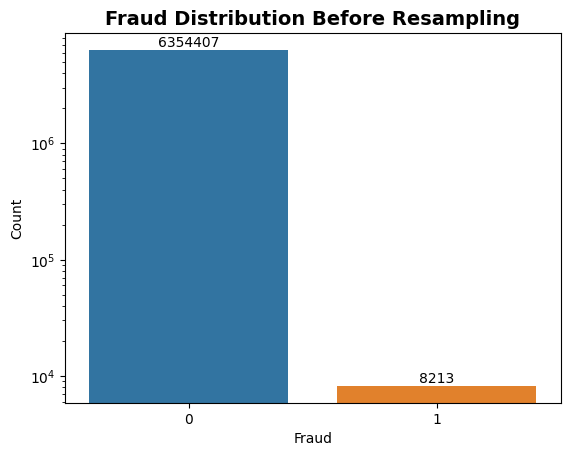

Fraud count
fraud
0    6354407
1       8213
Name: count, dtype: int64


In [8]:
# Create the count plot using the under-sampled DataFrame
ax = sns.countplot(x='fraud', data=df_eda)

# Calculate value counts for both classes
value_counts = df_eda['fraud'].value_counts()

# Add value counts as text labels on the bars
for i, v in enumerate(value_counts):
    ax.text(i, v + (-30), str(v), ha='center', va='bottom', fontsize=10)

# Apply log transformation to the y-axis
ax.set_yscale('log')

# Add title and labels
ax.set_title('Fraud Distribution Before Resampling', fontweight='bold', fontsize=14)
ax.set_xlabel('Fraud')
ax.set_ylabel('Count')

# Show the plot
plt.show()

# Print the original fraud counts
print('Fraud count')
print(df_eda['fraud'].value_counts())

The dataset is found to be severely imbalance. Hence, in preprocessing will carry out resampling and select models that is less sensitive to imbalance dataset in model selection and training. 

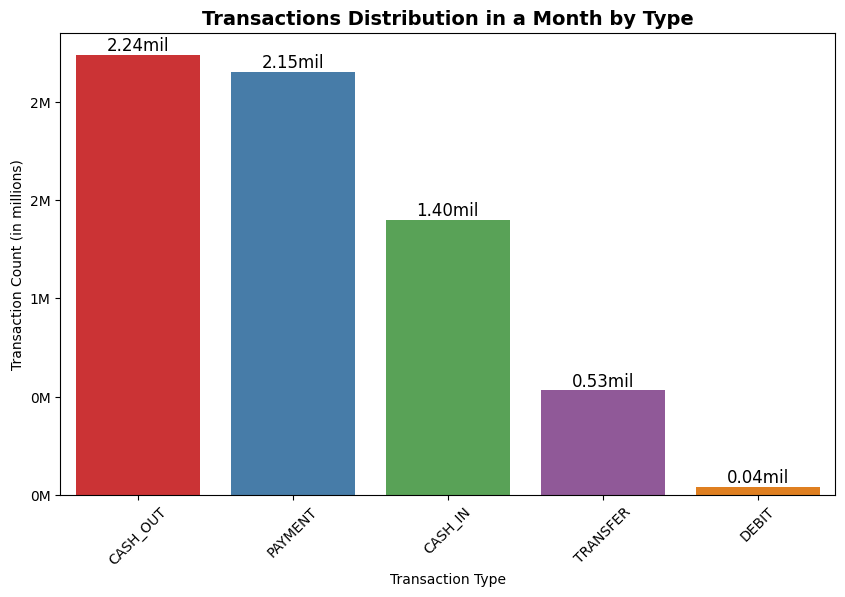

In [9]:
from matplotlib.ticker import FuncFormatter  # Import FuncFormatter

# Sort the bars in descending order by count
order = df_eda['type'].value_counts().index

# Create a countplot using Seaborn
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='type', data=df_eda, order=order, palette='Set1')
plt.xlabel('Transaction Type')
plt.title('Transactions Distribution in a Month by Type', fontweight='bold', fontsize=14)
plt.xticks(rotation=45)

# Add y-value labels in millions with two decimal points
def millions_formatter(x, pos):
    return f'{x / 1e6:.0f}M'  # Format with two decimal places

ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))  # Use FuncFormatter
plt.ylabel('Transaction Count (in millions)')
    
# Add y-value labels rounded to million
for p in ax.patches:
    height = p.get_height() / 1000000  # Convert to millions
    ax.annotate(f'{height:.2f}mil', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12)

plt.show()

We discover that **cash out** and **payment** to be the most recurring mode of transaction.

In [10]:
trans_amount = df_eda.groupby('type')['amount'].sum()
trans_amount

type
CASH_IN     2.363674e+11
CASH_OUT    3.944130e+11
DEBIT       2.271992e+08
PAYMENT     2.809337e+10
TRANSFER    4.852920e+11
Name: amount, dtype: float64

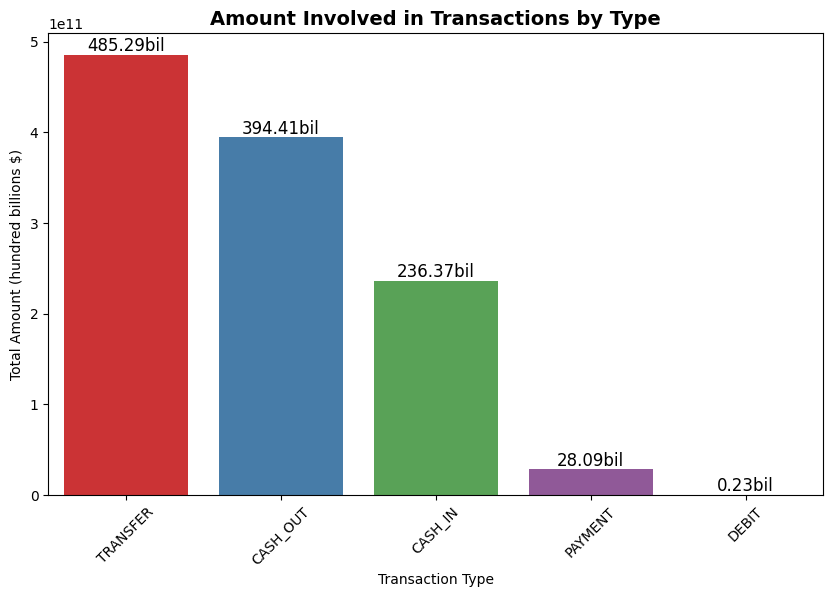

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the sum of amounts for each 'type' for fraudulent transactions
trans_amount = df_eda.groupby('type')['amount'].sum().reset_index()

# Sort the DataFrame in descending order by 'amount'
trans_amount_sorted = trans_amount.sort_values(by='amount', ascending=False)

# Set a Seaborn color palette (you can customize it as needed)
sns.set_palette("Set1")

# Create a bar plot with Seaborn, specifying the 'order' parameter
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='type', y='amount', data=trans_amount_sorted)

# Customize the plot
plt.title('Amount Involved in Transactions by Type', fontsize=14, fontweight='bold')
plt.xlabel('Transaction Type')
plt.xticks(rotation=45)


# Add y-value labels in billions with two decimal points
def billions_formatter(x, pos):
    return f'{x / 1e9:.0f}b'  # Format with two decimal places

#ax.yaxis.set_major_formatter(FuncFormatter(billions_formatter))  # Use FuncFormatter
plt.ylabel('Total Amount (hundred billions $)')

# Add y-value labels rounded to billion
for p in ax.patches:
    height = p.get_height() / 1000000000  # Convert to billions
    ax.annotate(f'{height:.2f}bil', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12)
    
# Show the plot
plt.show()

Despite cash out and payment to be the most recurring mode of transaction, dataset shows bank transfer being the transaction involving highest amount more than 800k of local currency followed by cash out of nearly 200k. 

In [12]:
# Calculate and print counts of fraud (fraud == 1) and genuine (fraud == 0) transactions by type
fraud_counts = df_eda[df_eda['fraud'] == 1].groupby('type')['fraud'].count().reset_index()
genuine_counts = df_eda[df_eda['fraud'] == 0].groupby('type')['fraud'].count().reset_index()

print("Counts of Fraudulent Transactions:")
print(fraud_counts)

print("\nCounts of Genuine Transactions:")
print(genuine_counts)

Counts of Fraudulent Transactions:
       type  fraud
0  CASH_OUT   4116
1  TRANSFER   4097

Counts of Genuine Transactions:
       type    fraud
0   CASH_IN  1399284
1  CASH_OUT  2233384
2     DEBIT    41432
3   PAYMENT  2151495
4  TRANSFER   528812


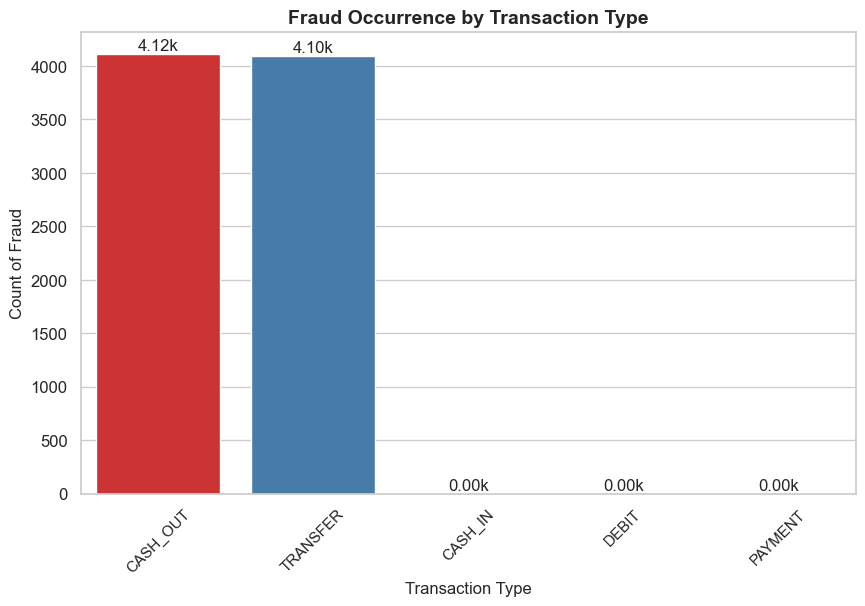

In [13]:
#Checking if fraud occur frequently in any specific type of transaction 

# Group the data by 'type' and calculate the sum of fraud, then sort in descending order
fraud_by_type = df_eda.groupby('type')['fraud'].sum().reset_index()
fraud_by_type = fraud_by_type.sort_values(by='fraud', ascending=False)

# Set the style to Seaborn's style
sns.set(style="whitegrid")

# Create a bar chart using Seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='type', y='fraud', data=fraud_by_type, palette='Set1', order=fraud_by_type['type'])
    
# Add y-value labels rounded to thousands
for p in ax.patches:
    height = p.get_height() / 1000  # Convert to thousands
    ax.annotate(f'{height:.2f}k', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12)

plt.xlabel('Transaction Type', fontsize=12)
plt.ylabel('Count of Fraud', fontsize=12)
plt.title('Fraud Occurrence by Transaction Type', fontweight='bold', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(fontsize=12)
plt.show()

From dataset, we identified Cash out and Transfer being the 2 type of transactions most prevalent to fraud occurence. This is a serious issue as cash out is one of the most occuring transaction while Transfer involve the highest monetary value. Fraud occuring at either one will result to monetary loss to the users. Service provider (e.g. bank) failure to notify user of potential fraud and carry out the necessary action to safeguard user's asset will be deemed unsatisfactory, leading to loss of trust and continued business. 

However, an overzealous system which frequently identify a genuine transaction as fraud would inconvenience the users. Hence, system implemented need to be based on a model that give minimal false positive and highest true positive detection. In this sense, user's asset is safeguard with minimal inconvenience, reassuring user of the provider reliability and trust is created leading to user's recommendations and potential new business opportunities. 

In [14]:
fraud_amount = df_eda[df_eda['fraud'] == 1].groupby('type')['amount'].sum()
fraud_amount

type
CASH_OUT    5.989202e+09
TRANSFER    6.067213e+09
Name: amount, dtype: float64

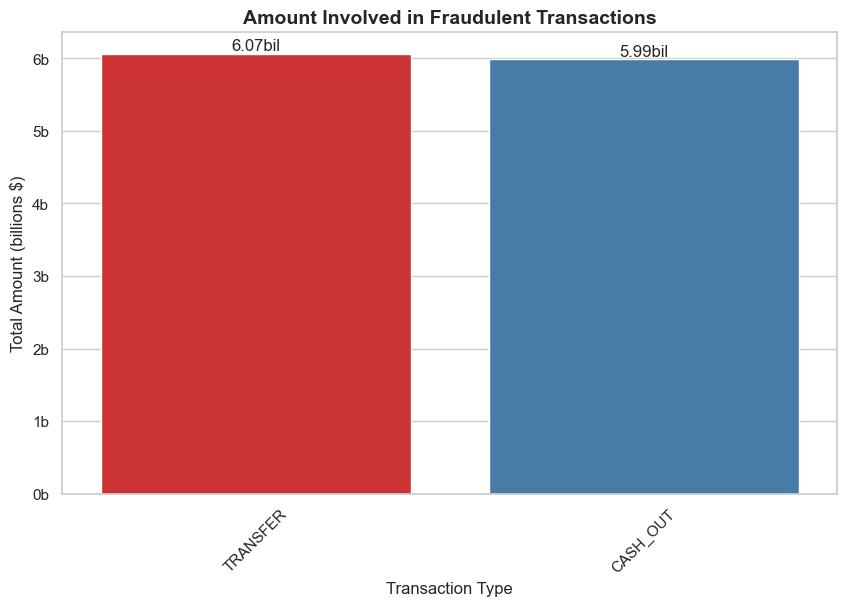

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the sum of amounts for each 'type' for fraudulent transactions
fraud_amount = df_eda[df_eda['fraud'] == 1].groupby('type')['amount'].sum().reset_index()

# Sort the DataFrame in descending order by 'amount'
amount_sorted = fraud_amount.sort_values(by='amount', ascending=False)

# Set a Seaborn color palette (you can customize it as needed)
sns.set_palette("Set1")

# Create a bar plot with Seaborn, specifying the 'order' parameter
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='type', y='amount', data=amount_sorted)

# Customize the plot
plt.title('Amount Involved in Fraudulent Transactions', fontsize=14, fontweight='bold')
plt.xlabel('Transaction Type')
plt.xticks(rotation=45)

# Add y-value labels in billions with two decimal points
def billions_formatter(x, pos):
    return f'{x / 1e9:.0f}b'  # Format with two decimal places

ax.yaxis.set_major_formatter(FuncFormatter(billions_formatter))  # Use FuncFormatter
plt.ylabel('Total Amount (billions $)')

# Add y-value labels rounded to billion
for p in ax.patches:
    height = p.get_height() / 1000000000  # Convert to billions
    ax.annotate(f'{height:.2f}bil', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12)
    
# Show the plot
plt.show()

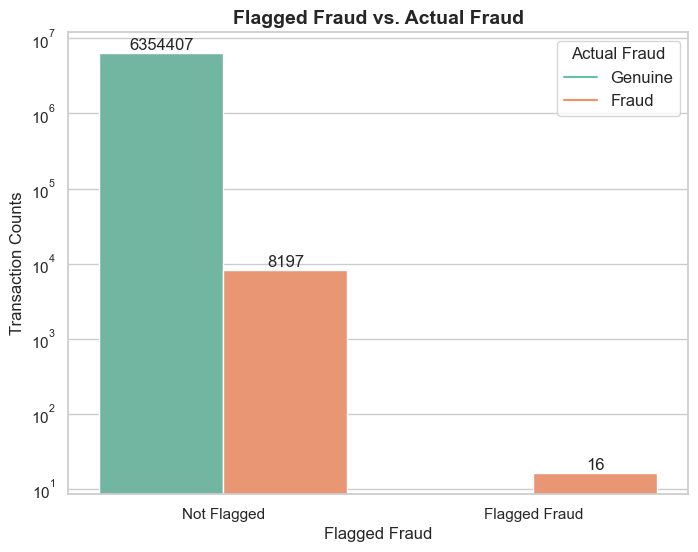

In [16]:
#Check actual fraud from flagged fraud

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Group the data by 'flagged_fraud' and 'fraud' and calculate the count
flagged_fraud_vs_actual_fraud = df_eda.groupby(['flagged_fraud', 'fraud']).size().reset_index(name='count')

# Set the style to Seaborn's style
sns.set(style="whitegrid")

# Create a bar chart using Seaborn
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='flagged_fraud', y='count', hue='fraud', data=flagged_fraud_vs_actual_fraud, palette='Set2',
                 hue_order=[0, 1])

# Apply a logarithmic scale to the y-axis
ax.set_yscale('log')

# Add value labels to the bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=12)

plt.xlabel('Flagged Fraud', fontsize=12)
plt.ylabel('Transaction Counts', fontsize=12)
plt.title('Flagged Fraud vs. Actual Fraud', fontweight='bold', fontsize=14)

# Customize x-axis ticks and format them as integers
plt.xticks([0, 1], ['Not Flagged', 'Flagged Fraud'])

# Customize legend labels
legend_labels = {0: 'Genuine', 1: 'Fraud'}

# Create custom handles for the legend
handles = [plt.Line2D([0], [0], color=sns.color_palette('Set2')[i], label=label) for i, label in legend_labels.items()]
plt.legend(handles=handles, title='Actual Fraud', title_fontsize='12', fontsize='12', loc='upper right')

plt.show()

From above, it's ascertained that those flagged fraud (set in system to flag any transactions attempting to transfer 200,000 local currency in a single transaction) to be fraudulent. However, 99.8 percent of fraudulent is not flagged fraud (transaction amounting less than 200,000 local currency). This show pre-existing system of flagging transaction >200,000 local currency is insignificant in fraud detection. 

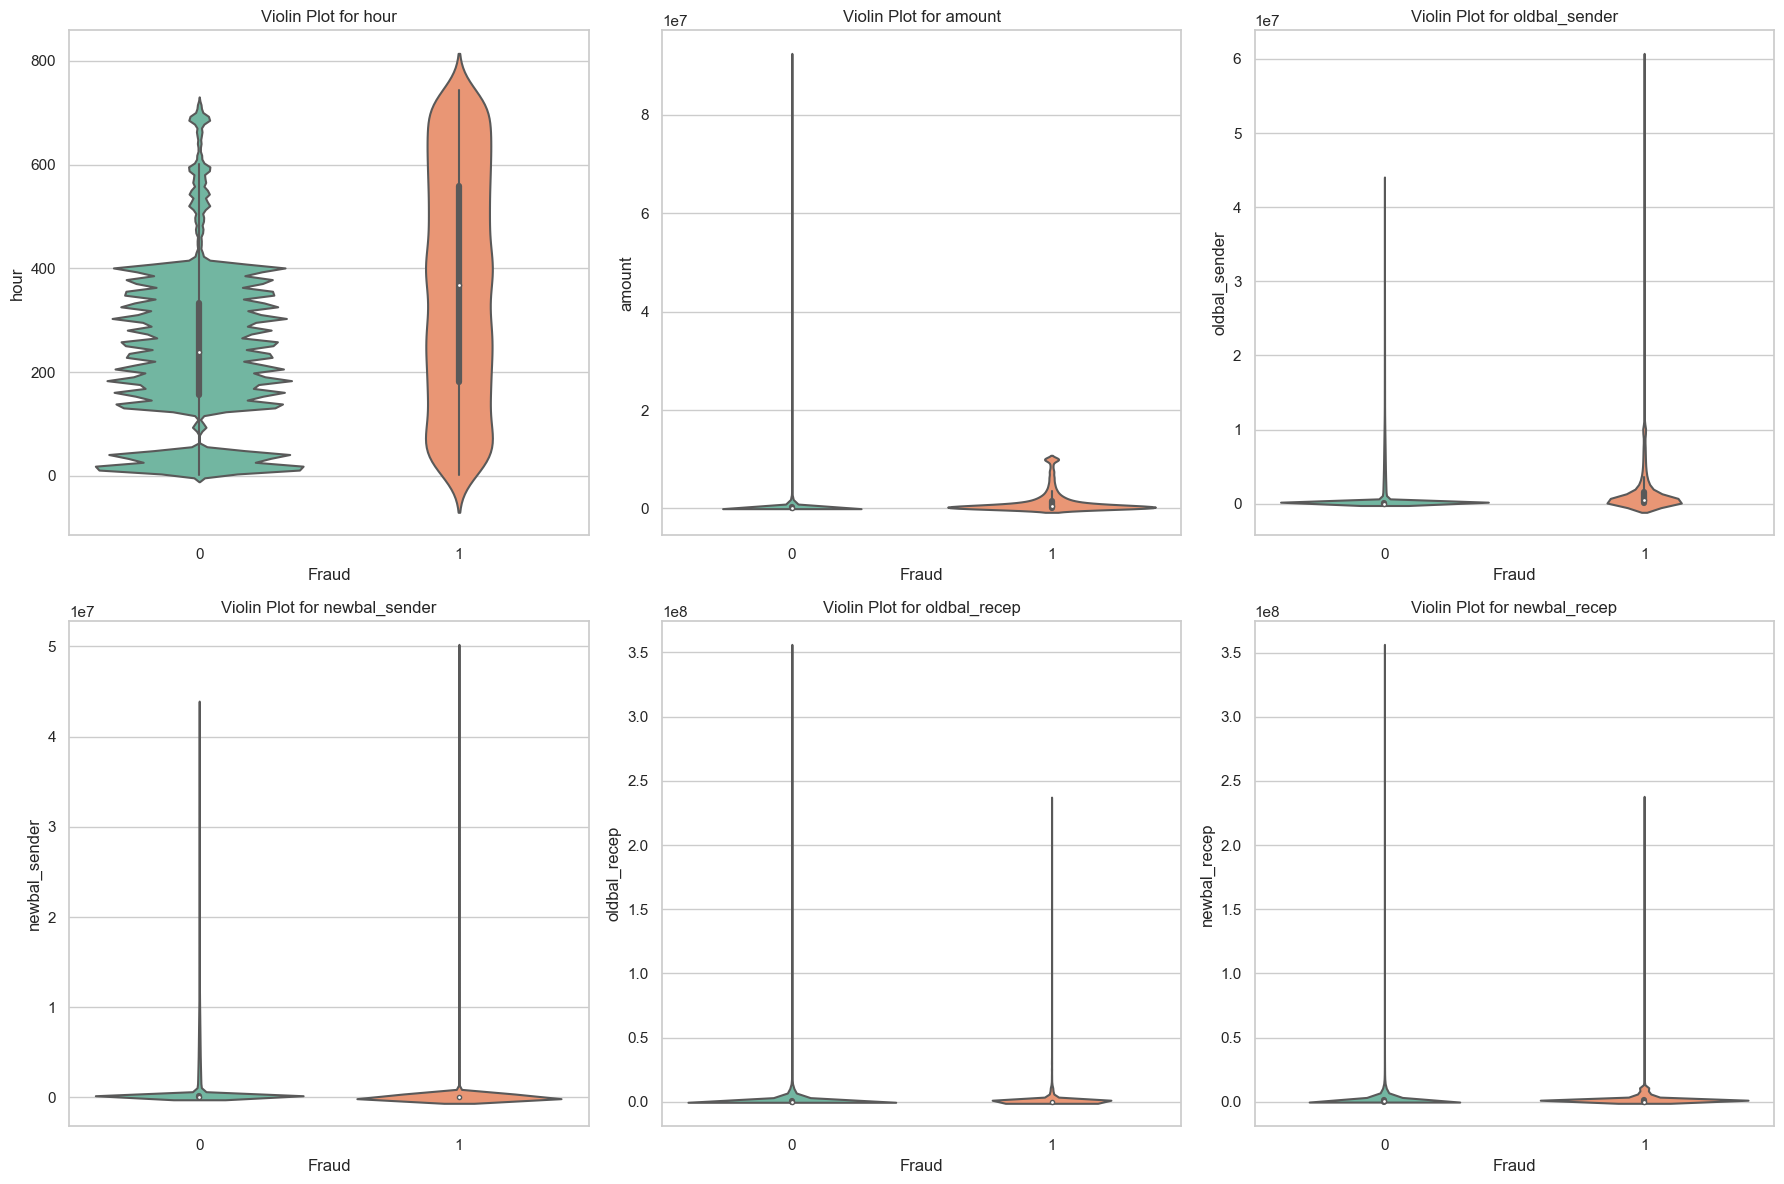

In [18]:
#visualising outliers on untranformed data (will take some time to run)

import seaborn as sns
import matplotlib.pyplot as plt

numerical_columns = ['hour', 'amount', 'oldbal_sender', 'newbal_sender', 'oldbal_recep', 'newbal_recep']

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Iterate through numerical columns and create violin plots
for i, col in enumerate(numerical_columns):
    sns.violinplot(x='fraud', y=col, data=df_eda, ax=axes[i], palette='Set2')
    axes[i].set_title(f"Violin Plot for {col}")
    axes[i].set_xlabel('Fraud')
    axes[i].set_ylabel(col)

# Adjust the layout
plt.tight_layout()
plt.show()

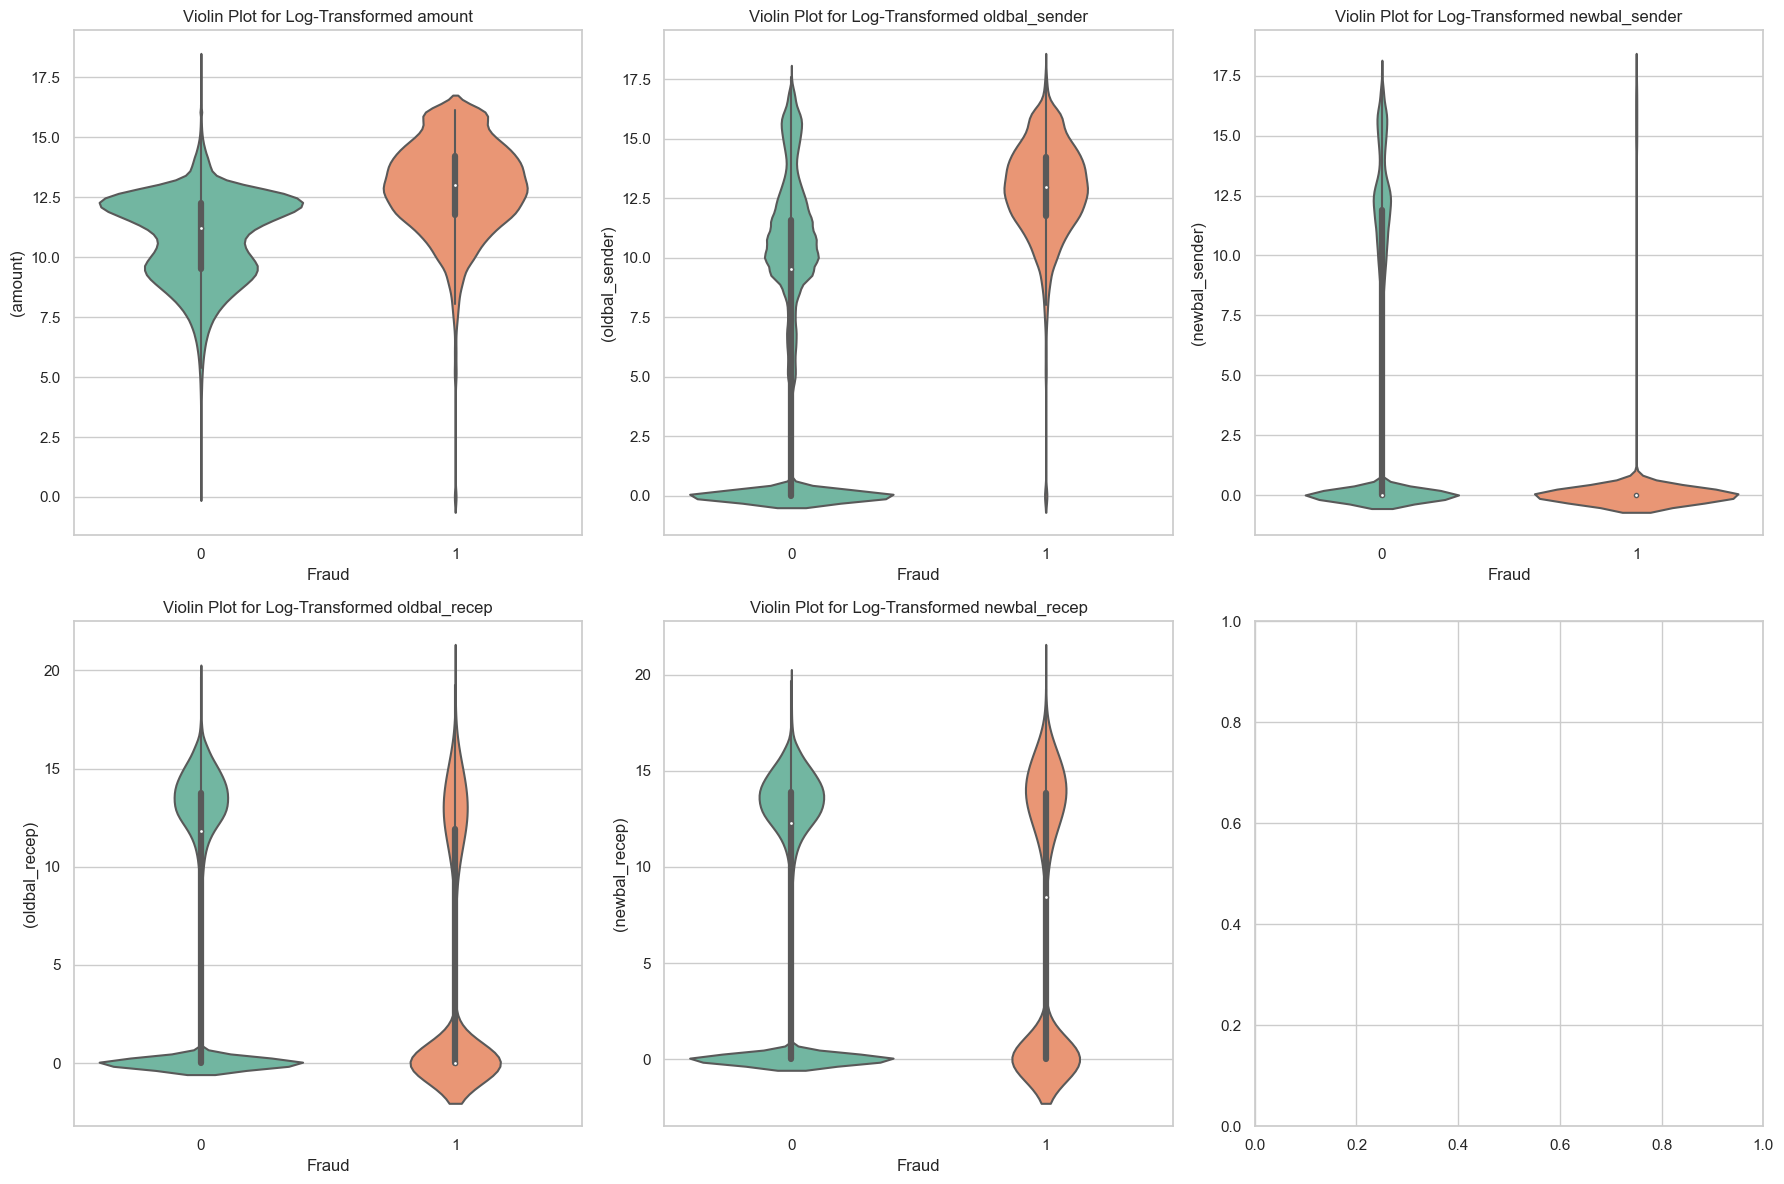

CPU times: total: 1min 38s
Wall time: 1min 52s


In [67]:
%%time

import numpy as np

# Columns to apply log transformation to
numerical_columns = ['amount', 'oldbal_sender', 'newbal_sender', 'oldbal_recep', 'newbal_recep']

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Iterate through the numerical columns, handle NaN and infinite values, and create violin plots
for i, col in enumerate(numerical_columns):
    # Handle NaN and infinite values by replacing them with a suitable value (e.g., 0)
    df_eda[col] = df_eda[col].replace([np.inf, -np.inf], np.nan).fillna(0)
    
    # Apply log transformation
    df_eda[f'{col}_log'] = np.log(df_eda[col] + 1)  # Adding 1 to avoid log(0)
    
    # Create violin plot for the log-transformed column
    sns.violinplot(x='fraud', y=f'{col}_log', data=df_eda, palette='Set2', ax=axes[i])
    
    axes[i].set_title(f"Violin Plot for Log-Transformed {col}")
    axes[i].set_xlabel('Fraud')
    axes[i].set_ylabel(f'({col})')

# Adjust the layout
plt.tight_layout()
plt.show()

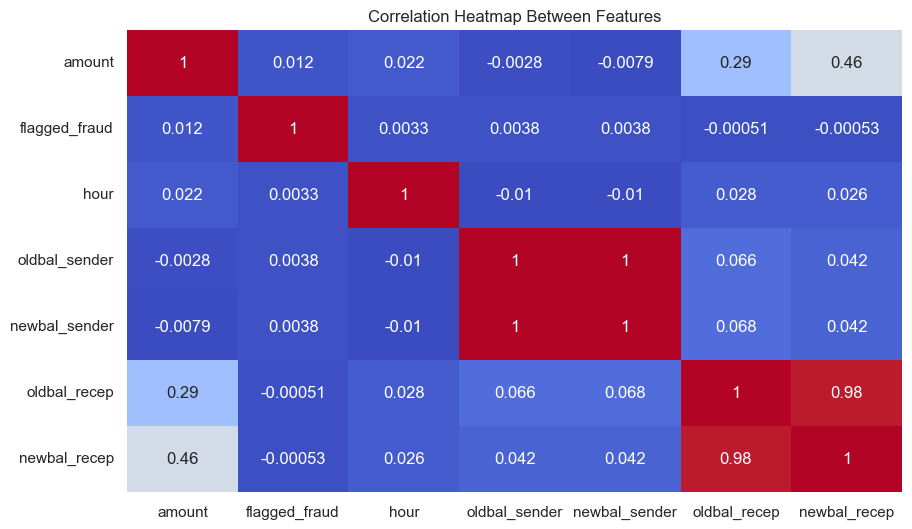

In [20]:
# Select the target variable (excluding 'fraud')
target = df_eda['fraud']

# Extract numerical features (excluding 'fraud' and 'object' columns)
numerical_features = df_eda.select_dtypes(include=['float64', 'uint8'])

# Add 'hour' and 'flagged_fraud' columns to numerical features
numerical_features['hour'] = df_eda['hour']
numerical_features['flagged_fraud'] = df_eda['flagged_fraud']

# Calculate the correlations
correlations = numerical_features.corrwith(target)

# Sort correlations in descending order
sorted_correlations = correlations.abs().sort_values(ascending=False)

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(numerical_features[sorted_correlations.index].corr(), annot=True, cmap="coolwarm", cbar=False)
plt.title("Correlation Heatmap Between Features")
plt.show()

In [4]:
#convert categorical (object dtype) into numerical

# Assuming 'type, sender and recipient' are categorical column in the DataFrame
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Convert the 'type' column to numerical
df_eda['type'] = label_encoder.fit_transform(df_eda['type'])

# Convert the 'sender' column to numerical
df_eda['sender'] = label_encoder.fit_transform(df_eda['sender'])

# Convert the 'recipient' column to numerical
df_eda['recipient'] = label_encoder.fit_transform(df_eda['recipient'])

df_eda.head()

,hour,type,amount,sender,oldbal_sender,newbal_sender,recipient,oldbal_recep,newbal_recep,fraud,flagged_fraud
0,1,3,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0
1,1,3,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0
2,1,4,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0
3,1,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0
4,1,3,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0


In [23]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column         Dtype  
---  ------         -----  
 0   hour           int64  
 1   type           int32  
 2   amount         float64
 3   sender         int32  
 4   oldbal_sender  float64
 5   newbal_sender  float64
 6   recipient      int32  
 7   oldbal_recep   float64
 8   newbal_recep   float64
 9   fraud          int64  
 10  flagged_fraud  int64  
dtypes: float64(5), int32(3), int64(3)
memory usage: 461.2 MB


In [ ]:
%%time
#sns.pairplot(df[selected_columns])

sns.pairplot(df_eda)
plt.show()

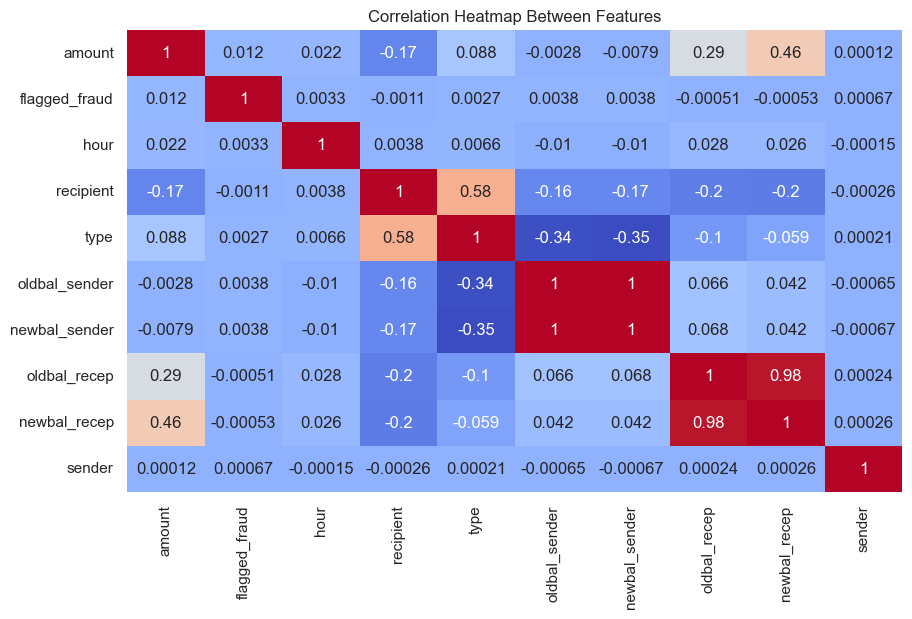

In [24]:
# Select the target variable (excluding 'fraud')
target = df_eda['fraud']

# Extract numerical features (excluding 'fraud' and 'object' columns)
numerical_features = df_eda.select_dtypes(include=['float64', 'uint8','int32'])

# Add 'hour' and 'flagged_fraud' columns to numerical features
numerical_features['hour'] = df_eda['hour']
numerical_features['flagged_fraud'] = df_eda['flagged_fraud']

# Calculate the correlations
correlations = numerical_features.corrwith(target)

# Sort correlations in descending order
sorted_correlations = correlations.abs().sort_values(ascending=False)

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(numerical_features[sorted_correlations.index].corr(), annot=True, cmap="coolwarm", cbar=False)
plt.title("Correlation Heatmap Between Features")
plt.show()

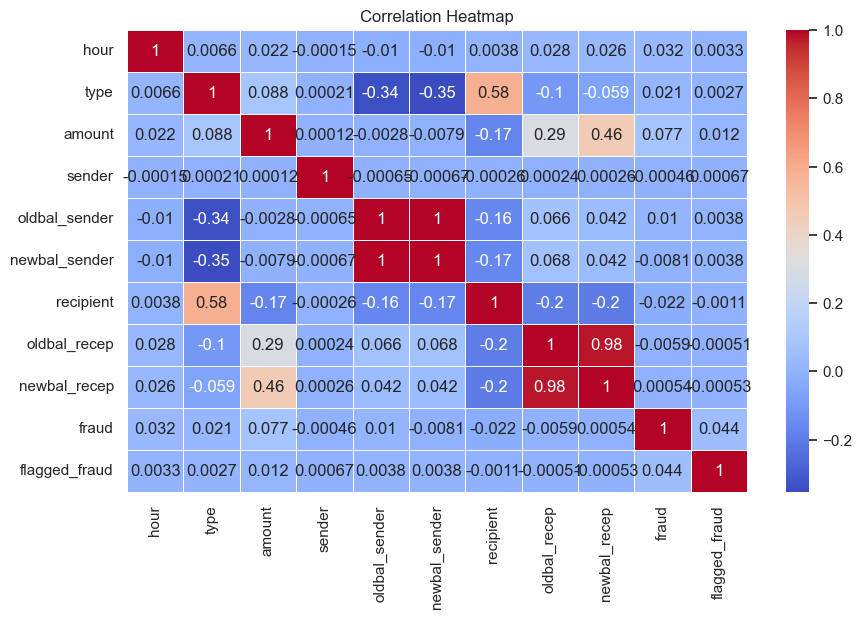

In [25]:
correlation_matrix = df_eda.corr()

# Sort the correlation of 'fraud' column in descending order
correlation_with_fraud = correlation_matrix['fraud'].sort_values(ascending=False)

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [26]:
df_eda.corr()['fraud'].sort_values(ascending=False)

fraud            1.000000
amount           0.076688
flagged_fraud    0.044109
hour             0.031578
type             0.020833
oldbal_sender    0.010154
newbal_recep     0.000535
sender          -0.000464
oldbal_recep    -0.005885
newbal_sender   -0.008148
recipient       -0.021963
Name: fraud, dtype: float64

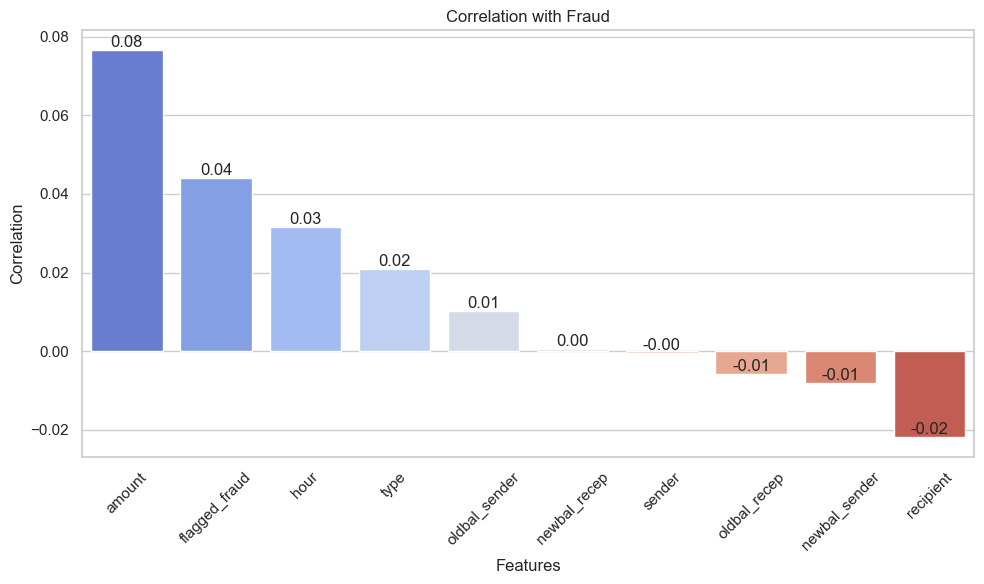

In [27]:
correlation_series = df_eda.corr()['fraud'].sort_values(ascending=False)
correlation_series = correlation_series.drop('fraud')

# Create a bar plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=correlation_series.index, y=correlation_series.values, palette="coolwarm")
plt.title("Correlation with Fraud")
plt.xlabel("Features")
plt.ylabel("Correlation")
plt.xticks(rotation=45)

# Annotate the bars with y-value labels
for index, value in enumerate(correlation_series.values):
    barplot.text(index, value, f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [28]:
# Is there a Common Sender and Recipient Pairs? Particularly with high transaction frequency/transaction amount? 

# Group the data by sender and recipient pairs and count the transaction frequency
pair_counts = df_eda.groupby(['sender', 'recipient']).size().reset_index(name='pair_frequency')

# Sort the pairs by frequency in descending order
sorted_pairs = pair_counts.sort_values(by='pair_frequency', ascending=False)

# Display the top N pairs with the highest frequency
top_N = 10  # adjust this number as needed
top_pairs = sorted_pairs.head(top_N)

top_pairs

,sender,recipient,pair_frequency
0,0,508534,1
4241732,4235617,562233,1
4241754,4235639,330388,1
4241753,4235638,1432275,1
4241752,4235637,511042,1
4241751,4235636,401697,1
4241750,4235635,43532,1
4241749,4235634,279467,1
4241748,4235633,464176,1
4241747,4235632,175512,1


Above investigation found that each sender-recipient pair in the dataset is unique and has occurred only once. As there is no significant relationship between sender & recipient, these 2 features will be excluded in model training. 

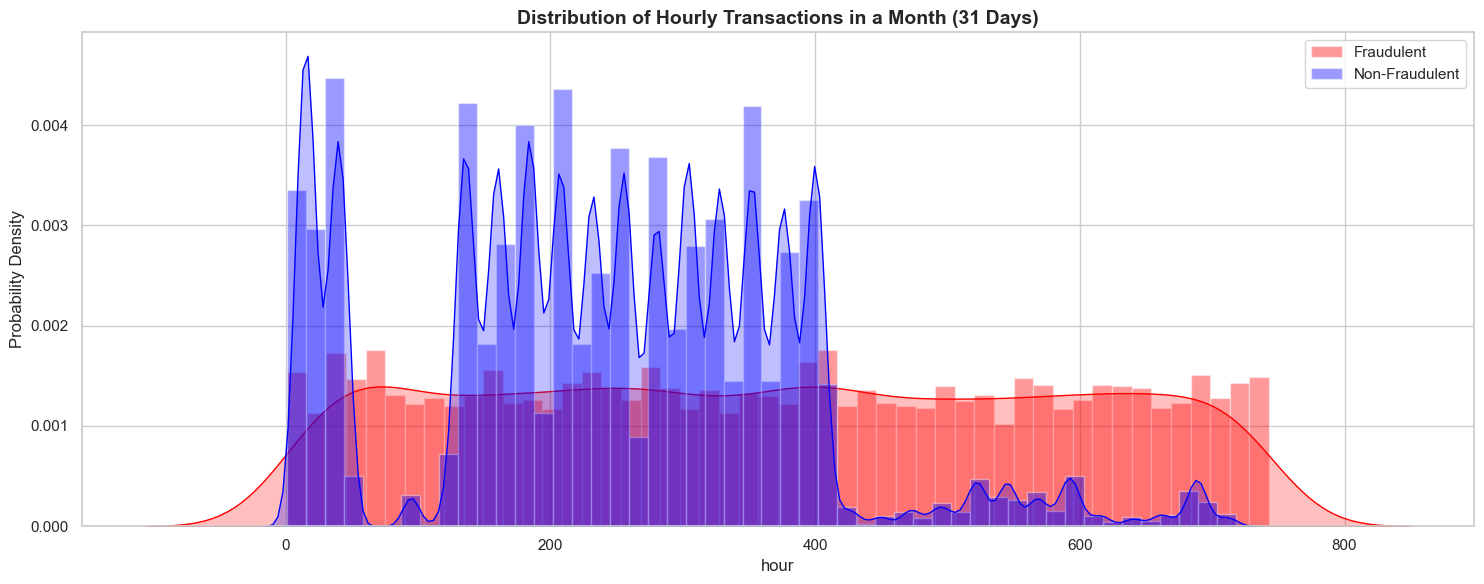

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

plt.ylabel('Probability Density')
plt.xlabel('Hour of the Month')
plt.title('Distribution of Hourly Transactions in a Month (31 Days)', fontweight='bold', fontsize=14)

# Filter the DataFrame to include only fraudulent transactions
fraudulent_data = df_eda[df_eda['fraud'] == 1]
non_fraudulent_data = df_eda[df_eda['fraud'] == 0]

# Plot the KDE and shade for fraudulent transactions
sns.distplot(fraudulent_data['hour'], bins=50, color='red', kde_kws={'shade': True}, label='Fraudulent')

# Plot the KDE and shade for non-fraudulent transactions on the same chart
sns.distplot(non_fraudulent_data['hour'], bins=50, color='blue', kde_kws={'shade': True}, label='Non-Fraudulent')

plt.tight_layout()
plt.legend()
plt.show()

In [30]:
# Define the range size (in this case, 24 hours)
range_size = 24

# Map the 'hour' values to the desired 24-hour range
df_eda['hour_of_day'] = ((df_eda['hour'] - 1) % range_size) + 1

#check output for hourly is correctly computed
rows_with_hour_25 = df_eda[df_eda['hour'] == 25]
rows_with_hour_25[['hour','hour_of_day']]

,hour,hour_of_day
574255,25,1
574256,25,1
574257,25,1
574258,25,1
574259,25,1
...,...,...
575848,25,1
575849,25,1
575850,25,1
575851,25,1


In [31]:
td_amount=df_eda[df_eda['amount']>0.0].amount.values

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


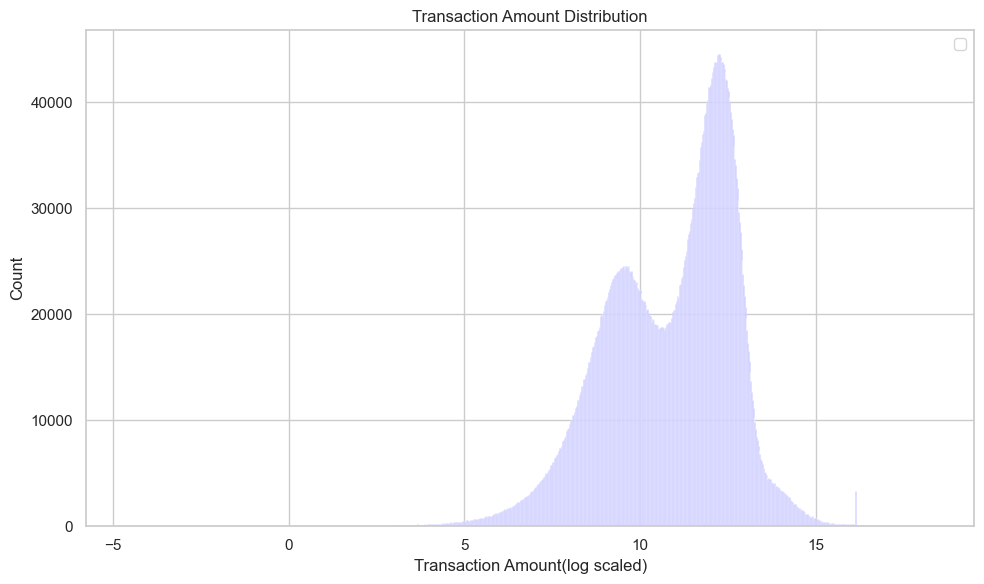

In [32]:
#visualizing the distribution of transaction amounts with logarithmic transformation

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot the histogram for Non-Fraudulent transactions

plt.hist(np.log(td_amount), bins=1000, color='blue', alpha=0.5)

plt.title('Transaction Amount Distribution')
plt.xlabel('Transaction Amount(log scaled)')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

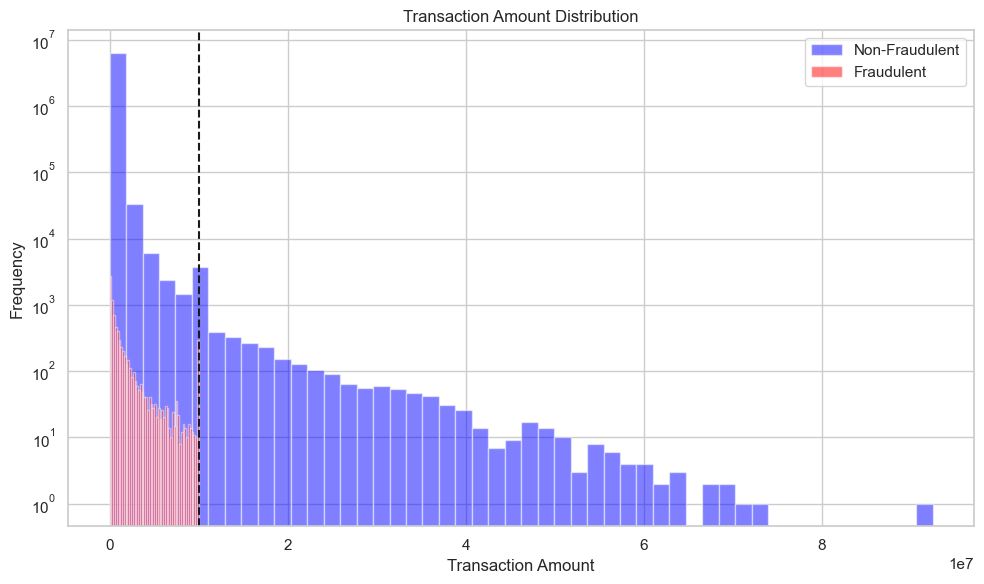

In [33]:
# Is there are any differences in transaction amounts between fraudulent and non-fraudulent transactions?

import matplotlib.pyplot as plt

non_fraudulent_transactions = df_eda[df_eda['fraud'] == 0]
fraudulent_transactions = df_eda[df_eda['fraud'] == 1]

plt.figure(figsize=(10, 6))

# Plot the histogram for Non-Fraudulent transactions
plt.hist(non_fraudulent_transactions['amount'], bins=50, color='blue', alpha=0.5, label='Non-Fraudulent', density=False, log=True)

# Plot the histogram for Fraudulent transactions
plt.hist(fraudulent_transactions['amount'], bins=50, color='red', alpha=0.5, label='Fraudulent', density=False, log=True)

plt.axvline(1E7, linestyle='--', color='k')
plt.title('Transaction Amount Distribution')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


From above, it seems transaction amount more than 10,000,000 local currecy is most likely to be genuine. Can this be a usable feature for fraud detection machine learning? Let's investigate further. 

In [34]:
(df_eda['amount']>1E7).sum()/len(df_eda)

0.00038396132410862193

In [35]:
df_eda['fraud'].value_counts()

fraud
0    6354407
1       8213
Name: count, dtype: int64

In [36]:
(df_eda['amount']>1E7).value_counts()

amount
False    6360177
True        2443
Name: count, dtype: int64

With further analysis, its is ascertained that the value above 10 mil local currency is insignificant, as it only comprise approx 0.04% of dataset. The dataset is too small to give significant result in model training. 

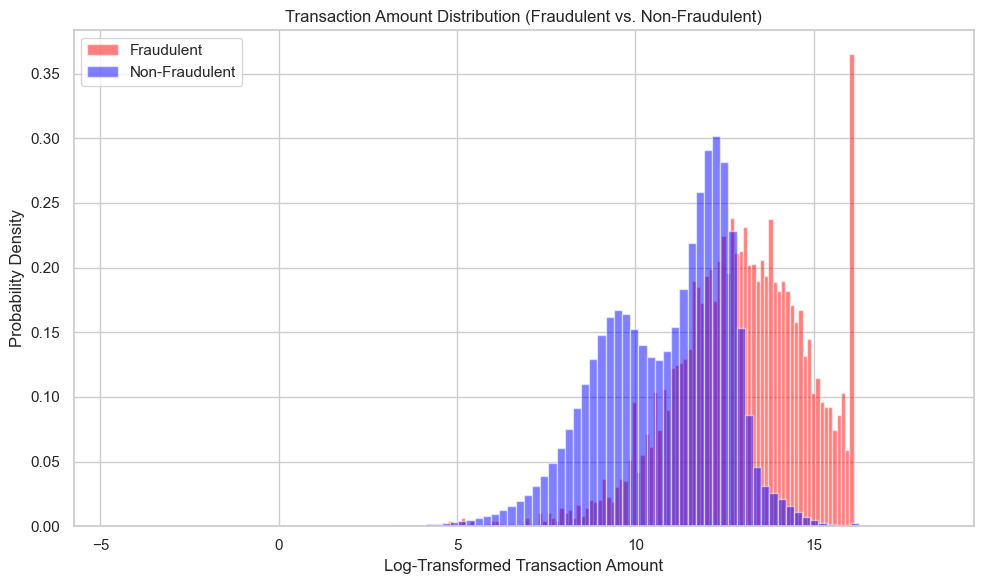

In [37]:
#checking if there's any insight from fraudulent vs non-fraudulent transaction amount in the previously compressed section

import matplotlib.pyplot as plt
import numpy as np

# Filter the DataFrame for fraudulent and non-fraudulent transactions
fraudulent_amounts = df_eda[df_eda['fraud'] == 1]['amount'].values
non_fraudulent_amounts = df_eda[df_eda['fraud'] == 0]['amount'].values

# Filter out non-positive values (zero or negative)
fraudulent_amounts = fraudulent_amounts[fraudulent_amounts > 0]
non_fraudulent_amounts = non_fraudulent_amounts[non_fraudulent_amounts > 0]

plt.figure(figsize=(10, 6))

# Apply log transformation to the x-axis (transaction amounts)
plt.hist(np.log(fraudulent_amounts), bins=100, color='red', alpha=0.5, label='Fraudulent', density=True)
plt.hist(np.log(non_fraudulent_amounts), bins=100, color='blue', alpha=0.5, label='Non-Fraudulent', density=True)

plt.title('Transaction Amount Distribution (Fraudulent vs. Non-Fraudulent)')
plt.xlabel('Log-Transformed Transaction Amount')
plt.ylabel('Probability Density')
plt.legend()

plt.tight_layout()
plt.show()

Notes: Faud vs Non-fraud can't be visualise in comparison without log transformation on y-axis. However, result seems dubious as the fraud amount on x-axis reached 10^16 (ten thousand trillion) when the max amount is 9.244552e+07.

Assuming the x-tick on 16/10^16 is 10^7 (local currency) as observed in previous chart, fradulent transaction has a high probability to occur between 10^12 and 10^16 mark. 

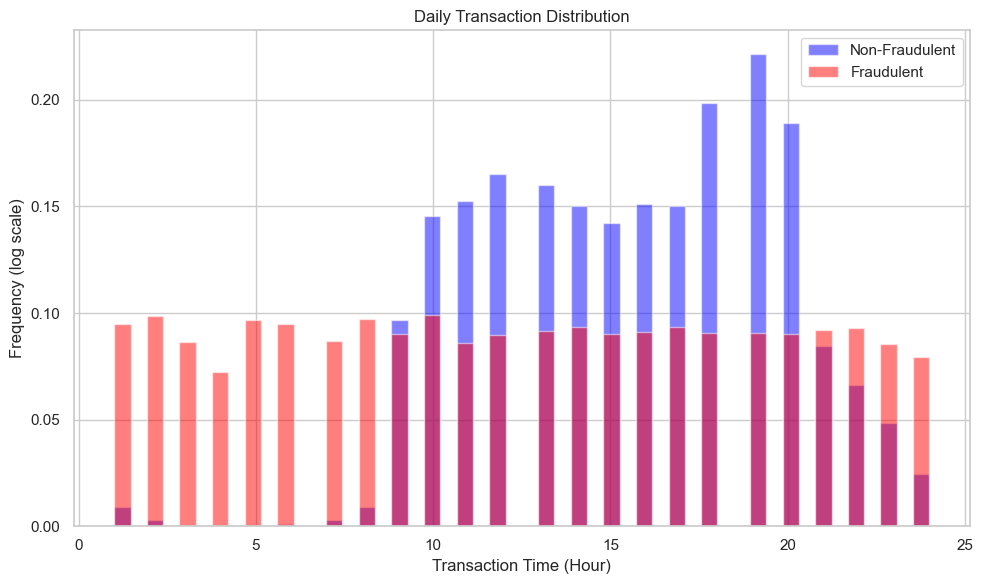

In [38]:
#Are there specific time periods when fraudulent transactions are more likely to occur?

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot the histogram for Non-Fraudulent transactions
plt.hist(non_fraudulent_transactions['hour_of_day'], bins=50, color='blue', alpha=0.5, label='Non-Fraudulent', density=True)

# Plot the histogram for Fraudulent transactions on the same chart
plt.hist(fraudulent_transactions['hour_of_day'], bins=50, color='red', alpha=0.5, label='Fraudulent', density=True)

plt.title('Daily Transaction Distribution')
plt.xlabel('Transaction Time (Hour)')
plt.ylabel('Frequency (log scale)')
plt.legend()

plt.tight_layout()
plt.show()

The probability of genuine transaction is higher during office hour while the probability of fraudulent transaction is higher during non-office hour, peak around pre-dawn. 

Implementation of real-time monitoring between 11PM to 8AM is highly recommended and potentially restrict high-value transactions during this time frame.

# Step 2. Data Preparation

As identified during EDA, data will be prepared to handle missing values(none in this case), outliers and imbalance dataset as needed.

In [55]:
df_pd = pd.read_csv('./DATA/PS_20174392719_1491204439457_log.csv') 

In [56]:
# Define the new column names as a list
new_column_names = ['hour', 'type', 'amount', 'sender', 'oldbal_sender', 'newbal_sender',
       'recipient', 'oldbal_recep', 'newbal_recep', 'fraud',
       'flagged_fraud']

# Assign the new column names to the DataFrame
df_pd.columns = new_column_names
df_pd.head() 

,hour,type,amount,sender,oldbal_sender,newbal_sender,recipient,oldbal_recep,newbal_recep,fraud,flagged_fraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [57]:
# One Hot Encode nominal data
type_dummy = pd.get_dummies(df_pd['type'], drop_first=False, dtype=int)  # Specify dtype=int to ensure binary encoding

# Convert the 'sender' column to numerical
df_pd['sender'] = label_encoder.fit_transform(df_pd['sender'])

# Convert the 'recipient' column to numerical
df_pd['recipient'] = label_encoder.fit_transform(df_pd['recipient'])

df = pd.concat([df_pd, type_dummy], axis=1)

#df.drop(columns=['type', 'sender', 'recipient'], inplace=True) #assuming no relationship between sender and recipient 
df.drop(columns=['type'], inplace=True) #no assumption on sender & recipient

# Convert column names to lowercase for standardisation and ease of processing computation
df.columns = df.columns.str.lower()
df.head()

,hour,amount,sender,oldbal_sender,newbal_sender,recipient,oldbal_recep,newbal_recep,fraud,flagged_fraud,cash_in,cash_out,debit,payment,transfer
0,1,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0,0,0,0,1,0
1,1,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0,0,0,0,1,0
2,1,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0,0,0,0,0,1
3,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0,0,1,0,0,0
4,1,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0,0,0,0,1,0


In [63]:
df.describe()

,hour,amount,sender,oldbal_sender,newbal_sender,recipient,oldbal_recep,newbal_recep,fraud,flagged_fraud,cash_in,cash_out,debit,payment,transfer
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,3.176678e+06,8.338831e+05,8.551137e+05,7.464270e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06,2.199226e-01,3.516633e-01,6.511783e-03,3.381461e-01,8.375622e-02
std,1.423320e+02,6.038582e+05,1.834064e+06,2.888243e+06,2.924049e+06,7.502455e+05,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03,4.141940e-01,4.774895e-01,8.043246e-02,4.730786e-01,2.770219e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,1.588332e+06,0.000000e+00,0.000000e+00,2.168950e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,3.176672e+06,1.420800e+04,0.000000e+00,4.322890e+05,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,4.765048e+06,1.073152e+05,1.442584e+05,1.132509e+06,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,6.353306e+06,5.958504e+07,4.958504e+07,2.722361e+06,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [60]:
#Check effect of log transormation in numerical form

# Make a copy of the original dataframe
df_log = df.copy()

# List of numerical columns to transform
numerical_columns = ['amount', 'oldbal_sender', 'newbal_sender', 'oldbal_recep', 'newbal_recep']

# Apply log transformation to each column
for column in numerical_columns:
    df_log[column] = np.log(df_log[column])
    
# Print the original and transformed df for comparison
print("Original df (before transformation):")
print(df.head())  

print("\nTransformed df (after log transformation):")
print(df_log.head())

Original df (before transformation):
   hour    amount   sender  oldbal_sender  newbal_sender  recipient  \
0     1   9839.64   757869       170136.0      160296.36    1662094   
1     1   1864.28  2188998        21249.0       19384.72    1733924   
2     1    181.00  1002156          181.0           0.00     439685   
3     1    181.00  5828262          181.0           0.00     391696   
4     1  11668.14  3445981        41554.0       29885.86     828919   

   oldbal_recep  newbal_recep  fraud  flagged_fraud  cash_in  cash_out  debit  \
0           0.0           0.0      0              0        0         0      0   
1           0.0           0.0      0              0        0         0      0   
2           0.0           0.0      1              0        0         0      0   
3       21182.0           0.0      1              0        0         1      0   
4           0.0           0.0      0              0        0         0      0   

   payment  transfer  
0        1         0  
1  

Chart plotted in EDA for comparison. To check if there's any insights using different data transformation method. 

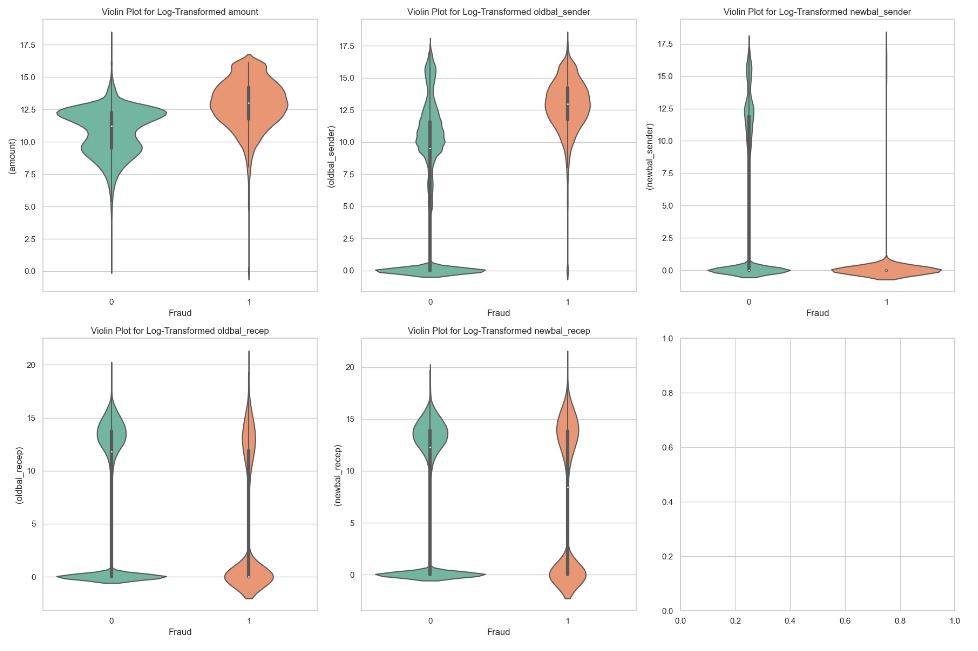

In [61]:
#Apply Winsorization on outliers - involves capping or truncating extreme values to a specified percentile, reduce the impact of outliers without completely removing them.

from scipy.stats.mstats import winsorize

# Make a copy of the original dataframe
df_winsor = df.copy()

# Define the numerical columns you want to apply winsorization to
numerical_columns = ['amount', 'oldbal_sender', 'newbal_sender', 'oldbal_recep', 'newbal_recep']

# Set the lower and upper bounds for winsorization
lower_bound = 0.05
upper_bound = 0.95

# Apply winsorization to each numerical column
for col in numerical_columns:
    winsorized_data = winsorize(df_winsor [col], limits=(lower_bound, upper_bound))
    df_winsor[col] = winsorized_data

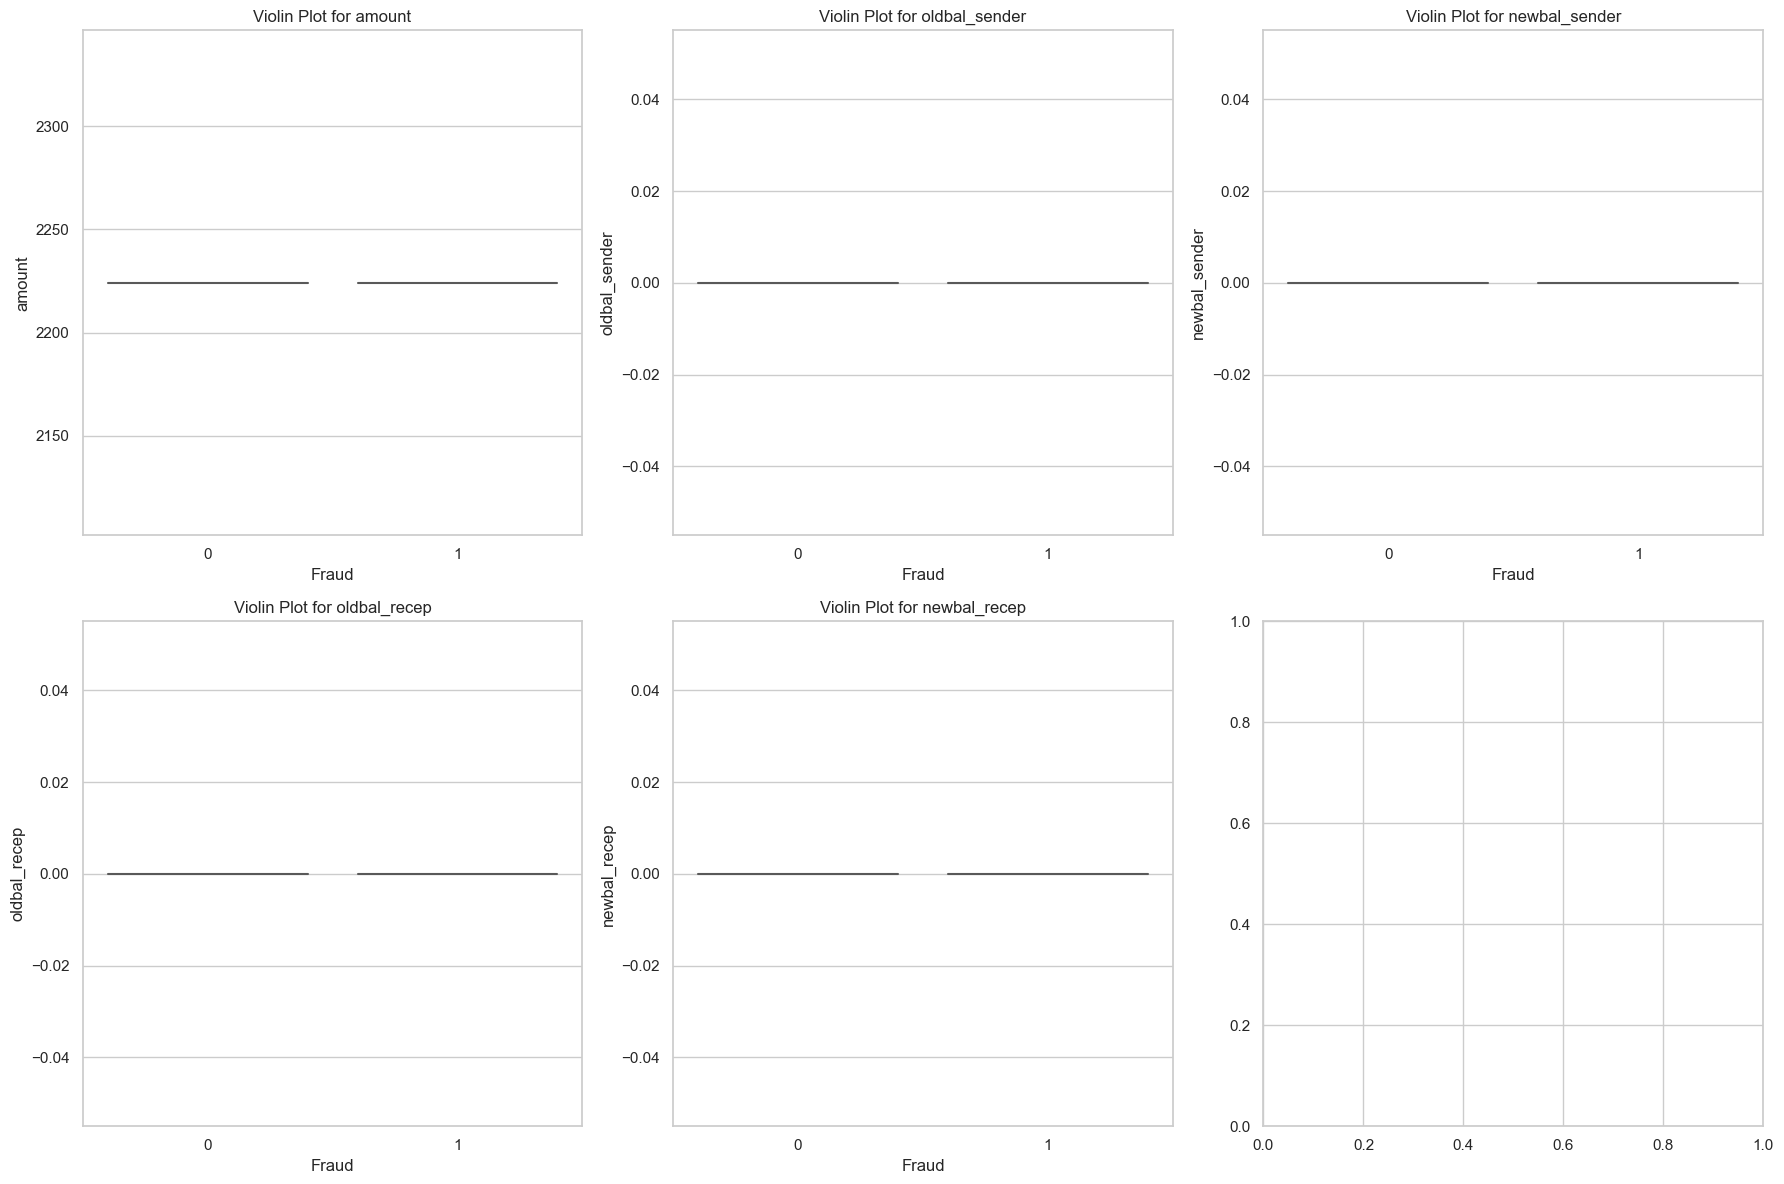

In [62]:
#Visualise Winsorization output

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Iterate through the numerical columns and create violin plots
for i, col in enumerate(numerical_columns):
    sns.violinplot(x='fraud', y=col, data=df_winsor, palette='Set2', ax=axes[i])
    axes[i].set_title(f"Violin Plot for {col}")
    axes[i].set_xlabel('Fraud')
    axes[i].set_ylabel(col)

# Adjust the layout
plt.tight_layout()
plt.show()

Winsorization often replaces extreme values (outliers) with less extreme values to reduce their impact on the distribution. As a result, if many values in a particular column were winsorized to a similar value, it can result to a horizontal line at specific values or very narrow distributions due to the Winsorization process.

In [64]:
#The IQR method identifies outliers as data points that fall below the first quartile minus a factor times the IQR or 
#above the third quartile plus a factor times the IQR. Can choose to remove or cap outliers using this method.

# Make a copy of the original dataframe
df_iqr = df.copy()

# Define the numerical columns
numerical_columns = ['amount', 'oldbal_sender', 'newbal_sender', 'oldbal_recep', 'newbal_recep']

# Function to handle outliers using IQR method
def handle_outliers_iqr(data, column, k=1.5):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - k * iqr
    upper_bound = q3 + k * iqr
    data[column] = np.where((data[column] < lower_bound) | (data[column] > upper_bound), np.nan, data[column])
    return data

# Apply the IQR method to handle outliers for each numerical column
for column in numerical_columns:
    df_iqr = handle_outliers_iqr(df_iqr, column)

# Drop rows with NaN values after handling outliers
df_iqr.dropna(inplace=True)

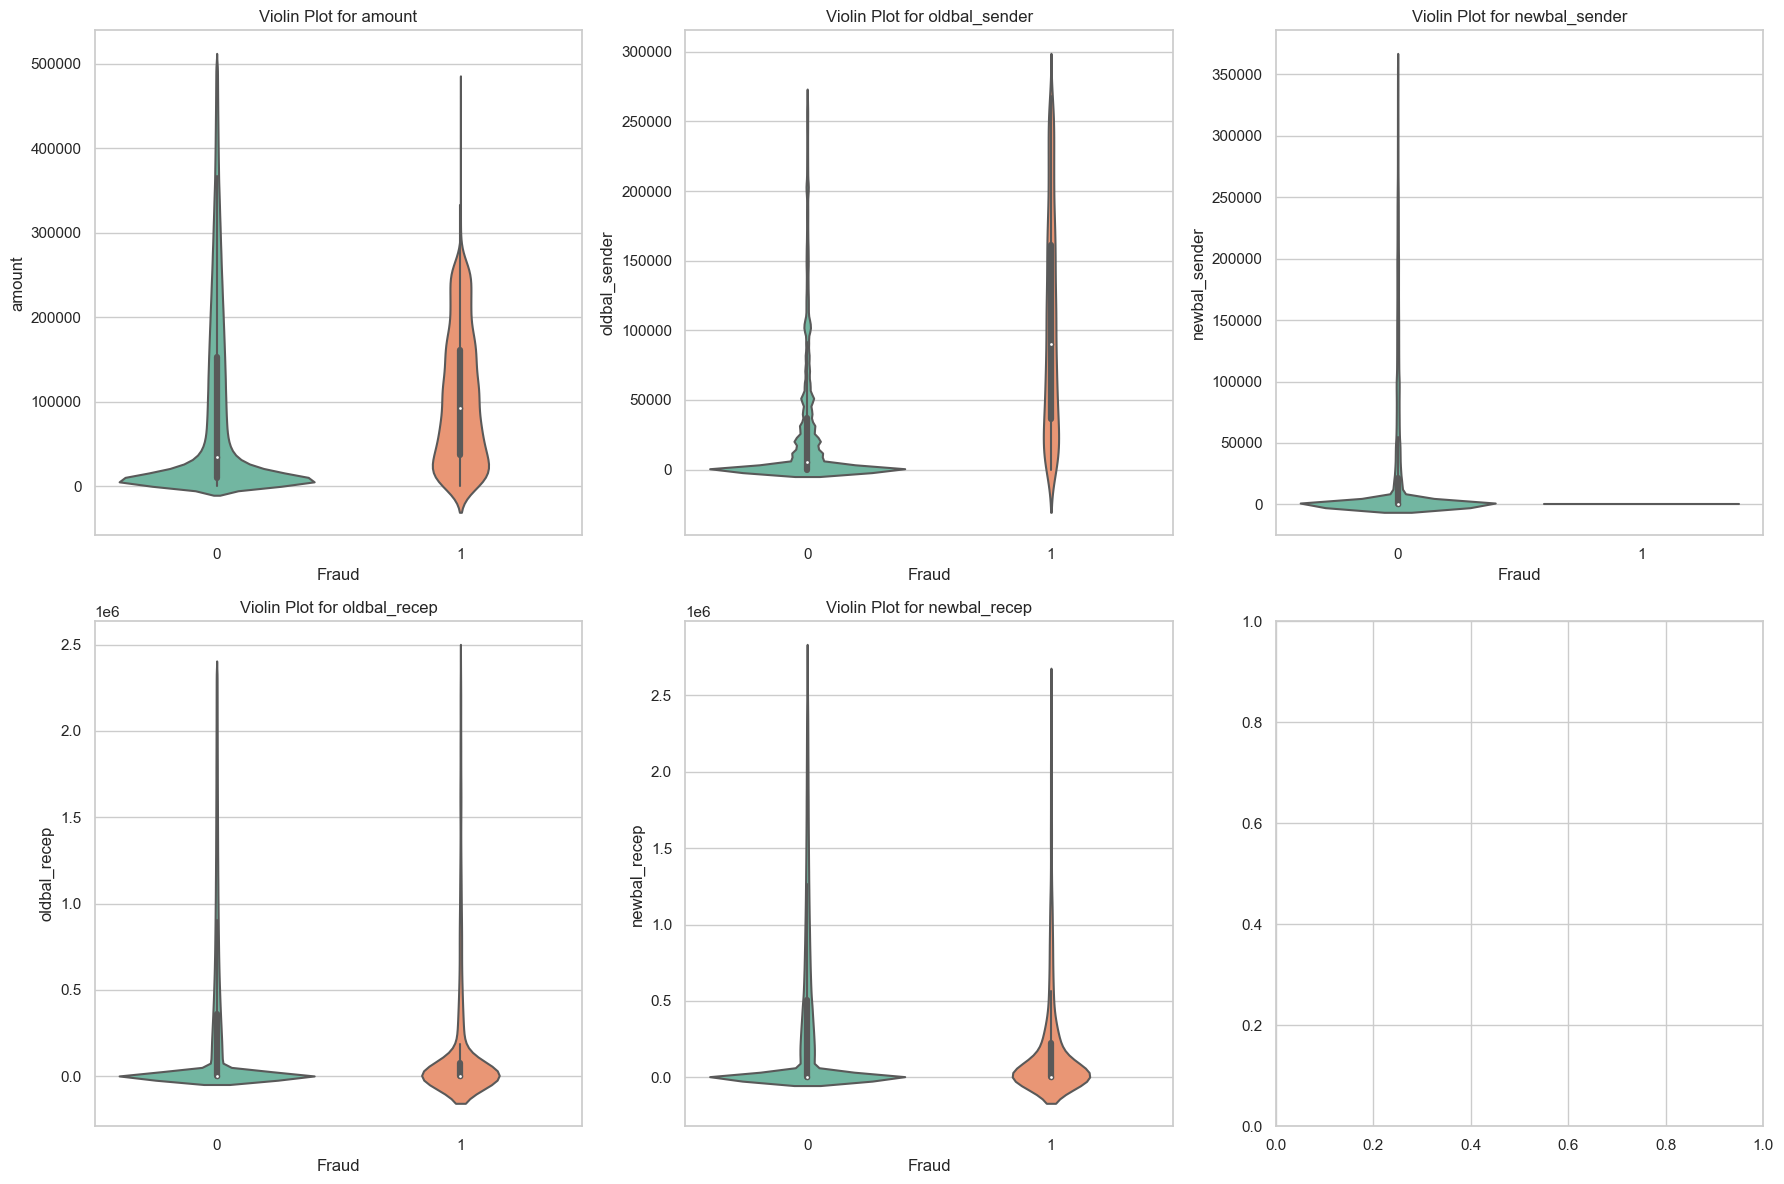

In [65]:
# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Iterate through the numerical columns and create violin plots
for i, col in enumerate(numerical_columns):
    sns.violinplot(x='fraud', y=col, data=df_iqr, palette='Set2', ax=axes[i])
    axes[i].set_title(f"Violin Plot for {col}")
    axes[i].set_xlabel('Fraud')
    axes[i].set_ylabel(col)

# Adjust the layout
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import skew

# Define the numerical columns
numerical_columns = ['amount', 'oldbal_sender', 'newbal_sender', 'oldbal_recep', 'newbal_recep']

# Calculate skewness for the specified columns
skewness = df[numerical_columns].skew().sort_values(ascending=False)

# Display the skewness values
skewness

In [ ]:
#Testing out visualisation on alternative scaling method - Z-score normalisation
#Basesd on skewness score above, Z-score is a better choice compare to Robust Scaling

from sklearn.preprocessing import StandardScaler

# Features for Z-score normalization
z_score_features = ['hour','amount', 'oldbal_sender', 'newbal_sender', 'oldbal_recep', 'newbal_recep']

# Apply Z-score normalization to selected features
scaler = StandardScaler()
df[z_score_features] = scaler.fit_transform(df[z_score_features])
df[z_score_features] = scaler.transform(df[z_score_features])

In [ ]:
# Create a 2x3 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(18, 12))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Iterate through the numerical columns and create violin plots
for i, col in enumerate(numerical_columns):
    sns.violinplot(x='fraud', y=col, data=df, palette='Set2', ax=axes[i])
    axes[i].set_title(f"Violin Plot for {col}")
    axes[i].set_xlabel('Fraud')
    axes[i].set_ylabel(col)

# Adjust the layout
plt.tight_layout()
plt.show()

No significant pattern related to fraud is found when visualising different scaling method on selected features. Hence, model training will proceed without data scaling. 

However, for 'hour' data, fraud is found to have a higher probability to occur between 11pm to 8am during EDA. In such cases, it can be beneficial to transform 'hour' data from 1-744 to 24 hours a day. 

In [68]:
# Define the range size (in this case, 24 hours)
range_size = 24

# Map the 'hour' values to the desired 24-hour range
df['hour_of_day'] = ((df['hour'] - 1) % range_size) + 1

#check output for hourly is correctly computed
rows_with_hour_25 = df[df['hour'] == 25]
rows_with_hour_25[['hour','hour_of_day']]

,hour,hour_of_day
574255,25,1
574256,25,1
574257,25,1
574258,25,1
574259,25,1
...,...,...
575848,25,1
575849,25,1
575850,25,1
575851,25,1


In [69]:
df.drop(columns=['hour'], inplace=True)
df.head()

,amount,sender,oldbal_sender,newbal_sender,recipient,oldbal_recep,newbal_recep,fraud,flagged_fraud,cash_in,cash_out,debit,payment,transfer,hour_of_day
0,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0,0,0,0,1,0,1
1,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0,0,0,0,1,0,1
2,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0,0,0,0,0,1,1
3,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0,0,1,0,0,0,1
4,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0,0,0,0,1,0,1


# Data Splitting & Balancing
Split dataset into training, validation, and test sets. Ensure the class distribution is maintained, especially in the training set due to class imbalance.

In [70]:
#Split the data before balancing into train, validate, test
from sklearn.model_selection import train_test_split

# define the target variable (dependent variable) as y
y = df['fraud']

# Take all columns except target as predictor columns
predictor_columns = [c for c in df.columns if c != 'fraud']

# Load the dataset as a pandas data frame
X = pd.DataFrame(df, columns = predictor_columns)

# Split data into a training-validation set and a test set (80-20 split)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Further split the training-validation set into training and validation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=1, stratify=y_train_val)

Majority dataset is allocated for training. Validation set is allocated with the same class distribution as the original dataset to allow assessment on the model's performance and carry out tuning while preserving the class imbalance (mimic real world data). Meanwhile, test set allows assessment on model's generalization performance on unseen data. Original class distribution is maintained, allowing evaluation on how well model performs on real-world, imbalanced data.

In [73]:
X.shape

(6362620, 14)

In [75]:
y.shape

(6362620,)

In [74]:
#Saving a copy of dataset in its original distribution

# Saving training data
training_data = pd.concat([X_train, y_train], axis=1)
training_data.to_csv('fraudtraining.csv', index=False)

# Saving testing data
testing_data = pd.concat([X_test, y_test], axis=1)
testing_data.to_csv('fraudtesting.csv', index=False)

# Saving validation data
validation_data = pd.concat([X_val, y_val], axis=1)
validation_data.to_csv('fraudvalidation.csv', index=False)

In [76]:
#Check fraud count distribution for train, test, validate ensure proper class 1 distribution

# Count fraud occurrences in training data
train_fraud_count_0 = y_train[y_train == 0].count()
train_fraud_count_1 = y_train[y_train == 1].count()

# Count fraud occurrences in testing data
test_fraud_count_0 = y_test[y_test == 0].count()
test_fraud_count_1 = y_test[y_test == 1].count()

# Count fraud occurrences in validation data
if 'X_val' in locals() and 'y_val' in locals():
    val_fraud_count_0 = y_val[y_val == 0].count()
    val_fraud_count_1 = y_val[y_val == 1].count()
else:
    val_fraud_count_0 = 0
    val_fraud_count_1 = 0

print("Training Data:")
print("Fraud Count == 0:", train_fraud_count_0)
print("Fraud Count == 1:", train_fraud_count_1)

print("\nTesting Data:")
print("Fraud Count == 0:", test_fraud_count_0)
print("Fraud Count == 1:", test_fraud_count_1)

if 'X_val' in locals() and 'y_val' in locals():
    print("\nValidation Data:")
    print("Fraud Count == 0:", val_fraud_count_0)
    print("Fraud Count == 1:", val_fraud_count_1)
else:
    print("\nValidation Data: Not Available")

Training Data:
Fraud Count == 0: 4066820
Fraud Count == 1: 5256

Testing Data:
Fraud Count == 0: 1270881
Fraud Count == 1: 1643

Validation Data:
Fraud Count == 0: 1016706
Fraud Count == 1: 1314


In [77]:
#Resampling training dataset to produce a balance dataset for model training

from imblearn.under_sampling import RandomUnderSampler

# Assuming X and y are the feature and target arrays
under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = under_sampler.fit_resample(X_train, y_train)

# Assuming X_resampled and y_resampled are the resampled feature and target arrays
training_data = pd.DataFrame(X_resampled, columns=predictor_columns)
training_data['fraud'] = y_resampled

# Save the under-sampled DataFrame as a CSV file
training_data.to_csv('fraudtraining_bal.csv', index=False)

# Model Training, Hyperparameter Tuning & Evaluation

4 algorithms is used on balanced training dataset, i.e. Logictic Regression (act as baseline), SVM, Random Forest and Gradient Boosting with default hyperparameters. Validation is carried out on validation set and generalization on unseen data using test set. Precision, recall, F1-score, and area under the ROC curve (AUC-ROC) to assess model performance. 

Each of the initial models undergo hyperparameter tuning using grid search and/or randomized search technique. Random search is carried out when grid search took longer time to compute. Based on random search result, grid search parameter is fined tune to shorter computation time. Results from respective model tunings are compared. Base models trained in following sequence: 


LR - Logistic Regression

SVM - Support Vector Machine

rf - Random Forest

XGB - eXtreme Gradient Boosting (an implementation of Gradient Boosting)

Update: Precision Recall curve added as it is more informative and give a more informative and give an accurate prediction of future classification performance compare to ROC curve. The plot evaluate the fraction of true positives (fraudulent) among positive predictions (predicted fraudulent).

**Establish Baseline Model Performance on Imbalance Dataset**

In [2]:
#Attempt to address severe class imbalance without resampling by using SVM. 
#Setting up baseline by training on imbalance dataset & check model performance in the absence of resampling

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load the training dataset
train_df = pd.read_csv('fraudtraining.csv')

# Load the validation dataset
validation_df = pd.read_csv('fraudvalidation.csv')

In [3]:
#Define the target variable and predictor columns for each dataset
# For the training dataset
y_train = train_df['fraud']
X_train = train_df.drop(columns=['fraud'])

# For the validation dataset
y_val = validation_df['fraud']
X_val = validation_df.drop(columns=['fraud'])

In [5]:
#create random subset in attempt to reduce training time

from sklearn.model_selection import train_test_split

# Load the training dataset
base_df = pd.read_csv('fraudtraining.csv')

# define the target variable (dependent variable) as y
y = base_df['fraud']

# Take all columns except target as predictor columns
predictor_columns = [c for c in base_df.columns if c != 'fraud']

# Load the dataset as a pandas data frame
X = pd.DataFrame(base_df, columns = predictor_columns)

# Split the data into a training set and a temporary subset (temp_set)
# The temp_set will contain a stratified sample of the data (stratify=y)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.8, stratify=y, random_state=42)

# Further split temp_set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [ ]:
%%time

'''
Attempted to run on full training dataset - kernel attempted: linear, rbf 
Attempted to run on subset of full training dataset.
'''
#take too long to run on CPU. Abort in setting baseline on imbalance dataset.
# Create an SVM classifier with class weight adjustment
# Set class_weight='balanced' to automatically adjust weights inversely proportional to class frequencies

svm_classifier = SVC(kernel='rbf', class_weight='balanced', probability=True)

# Train the SVM classifier on the imbalanced dataset
svm_classifier.fit(X_train, y_train)

print('SVM Training Accuracy (Imbalance Data):', svm_classifier.score(X_train, y_train))
y_pred_train = svm_classifier.predict(X_train)

print('Default Confusion Matrix')
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

print('Confusion Matrix (SVM Train Dataset)')
print(confusion_matrix(y_train, y_pred_train))

print('Classification Report (SVM Train Dataset)')
print(classification_report(y_train, y_pred_train))

In [ ]:
# Make predictions on the validation set
print('SVM Validation Accuracy (Imbalance Data):', svm_classifier.score(X_val, y_val))
y_pred_val = svm_classifier.predict(X_val)

# Evaluate the model
print('Default Confusion Matrix')
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

print('Confusion Matrix (SVM Validation Imbalance Data)')
print(confusion_matrix(y_val, y_pred_val))

print('Classification Report (SVM Validation Imbalance Data)')
print(classification_report(y_val, y_pred_val))

In [ ]:
#Plot a precision-recall curves which are appropriate for imbalanced datasets
#Precision-Recall Plot is more informative than the ROC Plot when evaluating binary classifiers on imbalanced datasets

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate the precision-recall curve
# Keep probabilities for the positive outcome only
probs = svm_classifier.predict_proba(X_val)[:, 1]

# predict class values
precision, recall, _ = precision_recall_curve(y_val, probs)
average_precision = average_precision_score(y_val, probs)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AP={average_precision:.2f})')
plt.grid(True)
plt.show()

**Base Models Training (LR, SVM, RF, XGBoost)**

In [2]:
# Load the training dataset
baltrain_df = pd.read_csv('fraudtraining_bal.csv')

# Load the validation dataset
validation_df = pd.read_csv('fraudvalidation.csv')

In [5]:
#Verify training dataset is balance

fraud_counts = baltrain_df ['fraud'].value_counts()
fraud_counts

fraud
0    5256
1    5256
Name: count, dtype: int64

In [3]:
#Define the target variable and predictor columns for each dataset

# For the training dataset
y_train = baltrain_df['fraud']
X_train = baltrain_df.drop(columns=['fraud'])

# For the validation dataset
y_val = validation_df['fraud']
X_val = validation_df.drop(columns=['fraud'])

In [8]:
X_train.shape

(10512, 14)

In [9]:
X_val.shape

(1018020, 14)

**LR Model Training & Tuning**

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Build the model
lr_classifier = LogisticRegression(random_state=1, max_iter=1000)

# Fit the model on the training data
lr_classifier.fit(X_train, y_train)

# Make predictions on the training data
y_train_pred = lr_classifier.predict(X_train)

# Calculate training accuracy
lrtrain_accuracy = accuracy_score(y_train, y_train_pred)
print("Logistic Regression Training Accuracy:", lrtrain_accuracy)

#Print default confusion matrix
print('Default Confusion Matrix')
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

# Print the confusion matrix and classification report for the test dataset
print('Confusion Matrix (LR Train Dataset):')
print(confusion_matrix(y_train, y_train_pred))

print('Classification Report (LR Train Dataset):')
print(classification_report(y_train, y_train_pred))

Logistic Regression Training Accuracy: 0.9355022831050228
Default Confusion Matrix
[['TN' 'FP']
 ['FN' 'TP']]
Confusion Matrix (LR Train Dataset):
[[5012  244]
 [ 434 4822]]
Classification Report (LR Train Dataset):
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      5256
           1       0.95      0.92      0.93      5256

    accuracy                           0.94     10512
   macro avg       0.94      0.94      0.94     10512
weighted avg       0.94      0.94      0.94     10512



In [30]:
# Validate on the validation dataset
y_val_pred = model.predict(X_val)

lrval_accuracy = accuracy_score(y_val, y_val_pred)
print('Logistic Regression Validation Accuracy:', lrval_accuracy)

# Print the confusion matrix
print('Default Confusion Matrix')
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))
print('Confusion Matrix (LR Validation Dataset):')
print(confusion_matrix(y_val, y_val_pred))

print('Classification Report (LR Validation Dataset):')
print(classification_report(y_val, y_val_pred))

Logistic Regression Validation Accuracy: 0.9509793520755977
Default Confusion Matrix
[['TN' 'FP']
 ['FN' 'TP']]
Confusion Matrix (LR Validation Dataset):
[[966913  49793]
 [   111   1203]]
Classification Report (LR Validation Dataset):
              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1016706
           1       0.02      0.92      0.05      1314

    accuracy                           0.95   1018020
   macro avg       0.51      0.93      0.51   1018020
weighted avg       1.00      0.95      0.97   1018020



In [33]:
%%time

#Regularisation & Scaling to fine-tune LR model

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Define the parameter grid for logistic regression
lr_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10, 100],
    'solver': ['lbfgs', 'newton-cg', 'sag', 'liblinear'],
}

# Create a Logistic Regression classifier
lr_classifier = LogisticRegression(random_state=1, max_iter=1000)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(lr_classifier, lr_params, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Train a Logistic Regression model with the best hyperparameters
best_lr_classifier = LogisticRegression(**grid_search.best_params_, random_state=1, max_iter=1000)
best_lr_classifier.fit(X_train, y_train)

Best Parameters: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.9657536942603404
CPU times: total: 1min 49s
Wall time: 3min 6s


LogisticRegression(C=100, max_iter=1000, penalty='l1', random_state=1,
                   solver='liblinear')

In [14]:
# Evaluate the model's performance
#blrtrain_accuracy = best_lr_classifier.score(X_train, y_train)
#print('Logistic Regression Train Accuracy (tuned):', blrtrain_accuracy)

# Evaluate on validation and test sets
blrval_accuracy = best_lr_classifier.score(X_val, y_val)
print('Logistic Regression Validation Accuracy (tuned):', blrval_accuracy )

# Print the confusion matrix
print('Default Confusion Matrix')
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))
print('Confusion Matrix (LR Validation Dataset):')
print(confusion_matrix(y_val, y_val_pred))

print('Classification Report (LR Validation Dataset):')
print(classification_report(y_val, y_val_pred))

Logistic Regression Validation Accuracy (tuned): 0.9505864324865916
Default Confusion Matrix
[['TN' 'FP']
 ['FN' 'TP']]
Confusion Matrix (LR Validation Dataset):
[[966913  49793]
 [   111   1203]]
Classification Report (LR Validation Dataset):
              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1016706
           1       0.02      0.92      0.05      1314

    accuracy                           0.95   1018020
   macro avg       0.51      0.93      0.51   1018020
weighted avg       1.00      0.95      0.97   1018020



The Logistic Regression (LR) model exhibits promising performance in fraud detection, achieving a high training accuracy of 95.08%. However, when evaluating the model on unseen data (validation and test sets) after hyperparameter tunng, the accuracy only improved slightly at 95.8% and precision of 0.01%. This indicate large number of False Positive (FP - The number of instances incorrectly predicted as fraudulent when they are not..) 

This situation is akin to a highly skilled detective (the model) who is excellent at identifying genuine transactions (correctly spotting legitimate customers) but occasionally misidentifies non-fraudulent cases as fraud (a moderate rate of false positives). The detective also excels in catching actual fraudsters (high recall for fraud cases), but the cost is occasionally flagging innocent individuals (false positives). 

**SVM Model Training & Tuning**

In [6]:
#Using Support Vector Machine to train model

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

clf = make_pipeline(StandardScaler(), SVC(kernel='linear', gamma = 'auto'))
clf.fit(X_train, y_train)

print('Support Vector Machine Training Accuracy:', clf.score(X_train, y_train))
svm_y_pred = clf.predict(X_train)

print('Default Confusion Matrix')
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

print('Confusion Matrix (SVM Train Dataset)')
print(confusion_matrix(y_train, svm_y_pred))

print('Classification Report (SVM Train Dataset)')
print(classification_report(y_train, svm_y_pred))

Support Vector Machine Training Accuracy: 0.9388318112633182
Default Confusion Matrix
[['TN' 'FP']
 ['FN' 'TP']]
Confusion Matrix (SVM Train Dataset)
[[5008  248]
 [ 395 4861]]
Classification Report (SVM Train Dataset)
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      5256
           1       0.95      0.92      0.94      5256

    accuracy                           0.94     10512
   macro avg       0.94      0.94      0.94     10512
weighted avg       0.94      0.94      0.94     10512



In [7]:
%%time
# Evaluate the model on the validation dataset

print('Support Vector Machine Validation Accuracy:', clf.score(X_val, y_val))
svm_yval_pred = clf.predict(X_val)

print('Default Confusion Matrix')
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

print('Confusion Matrix (SVM Validation Dataset)')
print(confusion_matrix(y_val, svm_yval_pred))

print('Classification Report (SVM Validation Dataset)')
print(classification_report(y_val, svm_yval_pred))

Support Vector Machine Validation Accuracy: 0.9515196165104811
Default Confusion Matrix
[['TN' 'FP']
 ['FN' 'TP']]
Confusion Matrix (SVM Validation Dataset)
[[967436  49270]
 [    84   1230]]
Classification Report (SVM Validation Dataset)
              precision    recall  f1-score   support

           0       1.00      0.95      0.98   1016706
           1       0.02      0.94      0.05      1314

    accuracy                           0.95   1018020
   macro avg       0.51      0.94      0.51   1018020
weighted avg       1.00      0.95      0.97   1018020

CPU times: total: 2min 16s
Wall time: 6min 27s


In [ ]:
%%time #take too long to run on CPU. Use RandomSearch instead
#Find best estimator for SVM (using GridSearchCV)

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Define the pipeline with a scaler and an SVM classifier
steps = [('scaler', StandardScaler()),
         ('SVM', SVC(probability=True))]

svc_pipeline = Pipeline(steps)

# Define the hyperparameters to search over
svc_params = {
    'SVM__C': [10,20],
    'SVM__gamma': ['auto', 1, 0.1],
    'SVM__kernel': ['rbf', 'poly']
}

# Create a GridSearchCV object
SVCclf = GridSearchCV(svc_pipeline, svc_params)

# Fit the GridSearchCV on the training data to find the best hyperparameters
SVCclf.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Parameters:", grid_search.best_params_)

# Get the best estimator and its corresponding score
best_estimator = SVCclf.best_estimator_
best_score = SVCclf.best_score_

print("Best Estimator:", best_estimator)
print("Best Score:", best_score)

# Get the best hyperparameters
best_hyperparameters = SVCclf.best_params_

# Create an SVM classifier with the best hyperparameters
best_svm_classifier = SVC(**best_estimator.named_steps['SVM'].get_params())
#best_svm_classifier = SVC(**best_estimator.named_steps['SVM'].get_params(), probability=True)

# Fit the SVM classifier on the training data
best_svm_classifier.fit(X_train, y_train)

In [ ]:
# To skip in the absence of tuned SVM using GridSearch
# Evaluate the best model on the test set (tuned using GridSearch)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on the test set
y_test_pred = best_svm_classifier.predict(X_test)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print('Support Vector Machine Test Accuracy (GS-tuned):', test_accuracy)

# Generate a confusion matrix
print('Default Confusion Matrix')
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

confusion = confusion_matrix(y_test, y_test_pred)
print('Confusion Matrix (SVM Test Dataset):')
print(confusion)

# Generate a classification report
report = classification_report(y_test, y_test_pred)
print('Classification Report (SVM Test Dataset):')
print(report)

In [8]:
%%time
#Find best estimator for SVM (using RandomizedSearchCV)
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

# Define the pipeline with a scaler and an SVM classifier
steps = [('scaler', StandardScaler()),
         ('SVM', SVC(probability=True))]

svc_pipeline = Pipeline(steps)

# Define the hyperparameter search space with reduced options
svc_params = {
    'SVM__C': [1, 10],
    'SVM__gamma': [1, 0.1, 0.01],
    'SVM__kernel': ['linear', 'rbf']
}

# Create a RandomizedSearchCV object with a specified number of iterations
SVCclf = RandomizedSearchCV(svc_pipeline, svc_params, n_iter=10, random_state=42)

# Fit the RandomizedSearchCV on the training data to find the best hyperparameters
SVCclf.fit(X_train, y_train)

# Print the best hyperparameters
best_hyperparameters = SVCclf.best_params_
print("Best Hyperparameters:", best_hyperparameters)

Best Hyperparameters: {'SVM__kernel': 'linear', 'SVM__gamma': 0.01, 'SVM__C': 10}
CPU times: total: 11min 10s
Wall time: 27min 16s


In [9]:
# Create an instance of the SVM classifier with the best hyperparameters
best_svm_model = SVC(kernel=best_hyperparameters['SVM__kernel'], C=best_hyperparameters['SVM__C'], gamma=best_hyperparameters['SVM__gamma'], probability=True)  

# Apply the same preprocessing as used during hyperparameter tuning
scaler = StandardScaler()  
X_train_scaled = scaler.fit_transform(X_train) 

# Fit the SVM model to the scaled training data
best_svm_model.fit(X_train_scaled, y_train)  

SVC(C=10, gamma=0.01, kernel='linear', probability=True)

In [20]:
%%time
# Evaluate the best model on the validation set (tuned using RandomSearch)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Apply the same transformation to validation data
X_val_scaled = scaler.transform(X_val)  

# Evaluate the model on the validation 
y_val_pred = best_svm_model.predict(X_val_scaled)  

# Calculate accuracy on the val set
SVMval_accuracy = accuracy_score(y_val, y_val_pred)
print('Support Vector Machine Validation Accuracy (RS-tuned):', SVMval_accuracy)

print('Default Confusion Matrix')
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

# Generate and print the confusion matrix
confusion_mat = confusion_matrix(y_val, y_val_pred)
print('Confusion Matrix (SVM Validation Dataset):')
print(confusion_mat)

# Generate and print the classification report
classification_rep = classification_report(y_val, y_val_pred)
print('Classification Report (SVM Validation Dataset):')
print(classification_rep)

Support Vector Machine Validation Accuracy (RS-tuned): 0.9420119447555058
Default Confusion Matrix
[['TN' 'FP']
 ['FN' 'TP']]
Confusion Matrix (SVM Validation Dataset):
[[957702  59004]
 [    29   1285]]
Classification Report (SVM Validation Dataset):
              precision    recall  f1-score   support

           0       1.00      0.94      0.97   1016706
           1       0.02      0.98      0.04      1314

    accuracy                           0.94   1018020
   macro avg       0.51      0.96      0.51   1018020
weighted avg       1.00      0.94      0.97   1018020

CPU times: total: 1min 11s
Wall time: 1min 21s


**RF Model Training & Tuning**

In [10]:
#Using Random forest for model training 

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#Creating RandomForestClassifier instance
rf_classifier = RandomForestClassifier(random_state=1)

#Train the model on the training dataset
rf_classifier.fit(X_train, y_train)

# Predict on the training data
rfy_train_pred = rf_classifier.predict(X_train)

# Calculate the training accuracy
rftrain_accuracy = accuracy_score(y_train, rfy_train_pred)

print('Random Forest Training Accuracy:', rftrain_accuracy)

print('Default Confusion Matrix')
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

print('Confusion Matrix (Training Dataset):')
print(confusion_matrix(y_train, rfy_train_pred))

print('Classification Report (Training Dataset):')
print(classification_report(y_train, rfy_train_pred))

Random Forest Training Accuracy: 1.0
Default Confusion Matrix
[['TN' 'FP']
 ['FN' 'TP']]
Confusion Matrix (Training Dataset):
[[5256    0]
 [   0 5256]]
Classification Report (Training Dataset):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5256
           1       1.00      1.00      1.00      5256

    accuracy                           1.00     10512
   macro avg       1.00      1.00      1.00     10512
weighted avg       1.00      1.00      1.00     10512



In [22]:
#Evaluate model on validation dataset

rfy_val_pred = rf_classifier.predict(X_val)
rfval_accuracy = accuracy_score(y_val, rfy_val_pred)

print('Random Forest Validation Accuracy:', rfval_accuracy)

print('Default Confusion Matrix')
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

print('Confusion Matrix (Validation Dataset):')
print(confusion_matrix(y_val, rfy_val_pred))

print('Classification Report (Validation Dataset):')
print(classification_report(y_val, rfy_val_pred))

Random Forest Validation Accuracy: 0.983502288756606
Default Confusion Matrix
[['TN' 'FP']
 ['FN' 'TP']]
Confusion Matrix (Validation Dataset):
[[999921  16785]
 [    10   1304]]
Classification Report (Validation Dataset):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1016706
           1       0.07      0.99      0.13      1314

    accuracy                           0.98   1018020
   macro avg       0.54      0.99      0.56   1018020
weighted avg       1.00      0.98      0.99   1018020



In [ ]:
%%time
#take too long to run on CPU (RandomSearchCV instead)
#Hyperparameter tuning for Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100], #number of decision trees in the forest. Increase improve performance & training time
    'max_depth': [None], #max. depth of each decision tree, deeper = more complex, may overfit
    'min_samples_split': [2, 5, 10], #min. number of samples to split an internal node, increase to prevent overfit
    'min_samples_leaf': [1, 5, 10], #minimum number of samples required to be at a leaf node, increase helps prevent overfitting
    'max_features': ['auto', 'sqrt', 'log2'], #number of features to consider when looking for the best split
    'criterion': ['gini', 'entropy'],  #function to measure the quality of a split
    'class_weight': [None, 'balanced'],  #handle class imbalance
    'bootstrap': [True]
}

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=1)

# Create the Grid Search object
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the Grid Search to your data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print('Best Hyperparameters:', best_params)

# Use the best model for predictions
gs_rf_model = grid_search.best_estimator_

In [ ]:
# Skip in absence of GridSearch tuning
# Check tuned Random forest model performance (using GridSearch)

rfy_val_pred = gs_rf_model.predict(X_val)
rfval_accuracy = accuracy_score(y_val, rfy_val_pred)

print('Random Forest Validation Accuracy(GS-tuned):', rfval_accuracy)

print('Default Confusion Matrix')
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

print('Confusion Matrix (Validation Dataset):')
print(confusion_matrix(y_val, rfy_val_pred))

print('Classification Report (Validation Dataset):')
print(classification_report(y_val, rfy_val_pred))

In [11]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define your hyperparameter grid
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 20, 30],
    'min_samples_split': [5, 8],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini']
}

# Create a RandomForestClassifier
rf = RandomForestClassifier()

# Create RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit RandomizedSearchCV to your data
random_search.fit(X_train, y_train)

# Access the best hyperparameters and estimator
best_params = random_search.best_params_
rf_classifier = random_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_params)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters:
{'n_estimators': 50, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_depth': 30, 'criterion': 'gini', 'bootstrap': False}
CPU times: total: 1.53 s
Wall time: 30.5 s


In [25]:
# Check tuned Random forest model performance (using RandomSearchCV)

# Train the RandomForestClassifier on the training data
rf_classifier.fit(X_train, y_train)

rsrfy_val_pred = rf_classifier.predict(X_val)
rsrfval_accuracy = accuracy_score(y_val, rsrfy_val_pred)

print('Random Forest Validation Accuracy(RS-tuned):', rsrfval_accuracy)

print('Default Confusion Matrix')
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

print('Confusion Matrix (Validation Dataset):')
print(confusion_matrix(y_val, rsrfy_val_pred))

print('Classification Report (Validation Dataset):')
print(classification_report(y_val, rsrfy_val_pred))

Random Forest Validation Accuracy(RS-tuned): 0.9848961709986052
Default Confusion Matrix
[['TN' 'FP']
 ['FN' 'TP']]
Confusion Matrix (Validation Dataset):
[[1001338   15368]
 [      8    1306]]
Classification Report (Validation Dataset):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1016706
           1       0.08      0.99      0.15      1314

    accuracy                           0.98   1018020
   macro avg       0.54      0.99      0.57   1018020
weighted avg       1.00      0.98      0.99   1018020



**XGBoost Model Training & Tuning**

In [25]:
#Trainig model using XGBoost Classifier (Gradient Boosting) 

import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Create an XGBoost classifier with default hyperparameters
xgb_classifier = xgb.XGBClassifier()

# Train the classifier on the training data
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [32]:
# Print the parameters used for the XGBoost classifier
params_used = xgb_classifier.get_params()

#print("Parameters used for XGBoost Classifier:")
for param, value in params_used.items():
    print(f"{param}: {value}")

objective: binary:logistic
use_label_encoder: None
base_score: None
booster: None
callbacks: None
colsample_bylevel: None
colsample_bynode: None
colsample_bytree: None
early_stopping_rounds: None
enable_categorical: False
eval_metric: None
feature_types: None
gamma: None
gpu_id: None
grow_policy: None
importance_type: None
interaction_constraints: None
learning_rate: None
max_bin: None
max_cat_threshold: None
max_cat_to_onehot: None
max_delta_step: None
max_depth: None
max_leaves: None
min_child_weight: None
missing: nan
monotone_constraints: None
n_estimators: 100
n_jobs: None
num_parallel_tree: None
predictor: None
random_state: None
reg_alpha: None
reg_lambda: None
sampling_method: None
scale_pos_weight: None
subsample: None
tree_method: None
validate_parameters: None
verbosity: None


In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Evaluate the model on the training set
xgby_train_pred = xgb_classifier.predict(X_train)
xgbtrain_accuracy = accuracy_score(y_train, xgby_train_pred)
train_confusion = confusion_matrix(y_train, xgby_train_pred)
train_report = classification_report(y_train, xgby_train_pred)

print("XG Boost Training Accuracy:", xgbtrain_accuracy)
print('Default Confusion Matrix')
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))
print("Confusion Matrix (Training Set):")
print(train_confusion)
print("Classification Report (Training Set):")
print(train_report)

# Evaluate the model on the validation set
xgby_val_pred = xgb_classifier.predict(X_val)
xgbval_accuracy = accuracy_score(y_val, xgby_val_pred)
val_confusion = confusion_matrix(y_val, xgby_val_pred)
val_report = classification_report(y_val, xgby_val_pred)

print("\nXG Boost Validation Accuracy:", xgbval_accuracy)
print('Default Confusion Matrix')
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))
print("Confusion Matrix (Validation Set):")
print(val_confusion)
print("Classification Report (Validation Set):")
print(val_report)

XG Boost Training Accuracy: 1.0
Default Confusion Matrix
[['TN' 'FP']
 ['FN' 'TP']]
Confusion Matrix (Training Set):
[[5256    0]
 [   0 5256]]
Classification Report (Training Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5256
           1       1.00      1.00      1.00      5256

    accuracy                           1.00     10512
   macro avg       1.00      1.00      1.00     10512
weighted avg       1.00      1.00      1.00     10512


XG Boost Validation Accuracy: 0.9895738787057229
Default Confusion Matrix
[['TN' 'FP']
 ['FN' 'TP']]
Confusion Matrix (Validation Set):
[[1006096   10610]
 [      4    1310]]
Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1016706
           1       0.11      1.00      0.20      1314

    accuracy                           0.99   1018020
   macro avg       0.55      0.99      0.60   1018020
wei

In [ ]:
%%time
#Takes too long to run in CPU (run RandomizedSearch instead)
#Hyperparameter tuning using GridSearch CV 

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Create an XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Define the hyperparameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],      # Number of boosting rounds
    'learning_rate': [0.01, 0.1, 0.2],  # Step size
    'max_depth': [3, 5, 7],             # Maximum depth of trees
    'min_child_weight': [1, 3, 5],      # Minimum sum of instance weight in a child node
    'subsample': [0.8, 0.9, 1.0],       # Fraction of samples used for growing trees
    'colsample_bytree': [0.8, 0.9, 1.0], # Fraction of features used for building each tree
    'gamma': [0, 0.1, 0.2],             # Minimum loss reduction required to make a partition
    'reg_alpha': [0, 0.1, 0.2],         # L1 regularization term on weights
    'reg_lambda': [1, 1.5, 2]           # L2 regularization term on weights
}

# Create a GridSearchCV object with cross-validation
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV on the training data to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Create an XGBoost classifier with the best hyperparameters
best_xgb_classifier = xgb.XGBClassifier(**best_params)

# Train the XGBoost model on the training data
best_xgb_classifier.fit(X_train, y_train)

In [14]:
#Hyperparameter tuning using RandomSearch CV

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Create an XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Define the hyperparameter search space
param_dist = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.2],
    'reg_lambda': [1, 1.5, 2]
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=xgb_classifier,
    param_distributions=param_dist,
    n_iter=10,  # Number of random combinations to try
    cv=5,        # Number of cross-validation folds
    scoring='accuracy',
    random_state=42  # For reproducibility
)

# Fit the RandomizedSearchCV on the training data to find the best hyperparameters
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Create an XGBoost classifier with the best hyperparameters
best_xgb_classifier = xgb.XGBClassifier(**best_params)

# Train the XGBoost model on the training data
best_xgb_classifier.fit(X_train, y_train)

Best Hyperparameters: {'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.9}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [30]:
# Print the parameters used for the XGBoost classifier
params_used = best_xgb_classifier.get_params()

#print("Parameters used for XGBoost Classifier:")
for param, value in params_used.items():
    print(f"{param}: {value}")

objective: binary:logistic
use_label_encoder: None
base_score: None
booster: None
callbacks: None
colsample_bylevel: None
colsample_bynode: None
colsample_bytree: 0.9
early_stopping_rounds: None
enable_categorical: False
eval_metric: None
feature_types: None
gamma: 0.2
gpu_id: None
grow_policy: None
importance_type: None
interaction_constraints: None
learning_rate: 0.1
max_bin: None
max_cat_threshold: None
max_cat_to_onehot: None
max_delta_step: None
max_depth: 5
max_leaves: None
min_child_weight: 1
missing: nan
monotone_constraints: None
n_estimators: 200
n_jobs: None
num_parallel_tree: None
predictor: None
random_state: None
reg_alpha: 0
reg_lambda: 1.5
sampling_method: None
scale_pos_weight: None
subsample: 0.8
tree_method: None
validate_parameters: None
verbosity: None


In [31]:
# Predict on the validation set
xgby_val_pred = best_xgb_classifier.predict(X_val)

# Evaluate the model on the validation set
xgb_accuracy = accuracy_score(y_val, xgby_val_pred)
confusion = confusion_matrix(y_val, xgby_val_pred)
report = classification_report(y_val, xgby_val_pred)

print("XGBoost Validation Accuracy (RS-tuned):", xgb_accuracy)
print('Default Confusion Matrix')
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))
print("Confusion Matrix:")
print(confusion)
print("Classification Report:")
print(report)

XGBoost Validation Accuracy (RS-tuned): 0.9876092807606923
Default Confusion Matrix
[['TN' 'FP']
 ['FN' 'TP']]
Confusion Matrix:
[[1004096   12610]
 [      4    1310]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1016706
           1       0.09      1.00      0.17      1314

    accuracy                           0.99   1018020
   macro avg       0.55      0.99      0.58   1018020
weighted avg       1.00      0.99      0.99   1018020



# Model Ensemble

Ensemble Techniques:
After selecting the best individual model, you can consider applying ensemble techniques such as stacking. Stacking involves training a meta-model on the predictions of the base models.
Use stacking to combine the strengths of the best-performing model and the other two models, including potentially KNN and DBSCAN.

In [15]:
#Using Stacking ensemble 

from sklearn.ensemble import StackingClassifier

# Create a list of (model_name, model_instance) tuples for base models
base_models = [('LR', best_lr_classifier), ('SVM', best_svm_model), ('RF', rf_classifier), ('XGB', xgb_classifier)]

# Create a meta-model (classifier or regressor)
meta_model = RandomForestClassifier(random_state=1)

# Create a StackingClassifier
stacking_classifier = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Fit the StackingClassifier on the training data
stacking_classifier.fit(X_train_scaled, y_train)

StackingClassifier(estimators=[('LR',
                                LogisticRegression(C=100, max_iter=1000,
                                                   penalty='l1', random_state=1,
                                                   solver='liblinear')),
                               ('SVM',
                                SVC(C=10, gamma=0.01, kernel='linear',
                                    probability=True)),
                               ('RF',
                                RandomForestClassifier(bootstrap=False,
                                                       max_depth=30,
                                                       min_samples_leaf=2,
                                                       min_samples_split=8,
                                                       n_estimators=50)),
                               ('XGB',
                                XGBClassifier(base_score=None, booster=Non...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...))],
                   final_estimator=RandomForestClassifier(random_state=1))

In [38]:
#saving as pickle model

import pickle #after model.fit

with open('fraudetect_model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [35]:
#Evaluate the ensemble models on the validation set

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Make predictions on the validation data using the stacking ensemble model
y_valstack_pred = stacking_classifier.predict(X_val_scaled)

# Calculate accuracy of stacking ensemble
val_stack_accuracy = accuracy_score(y_val, y_valstack_pred)
print("Stacking Ensemble Validation Accuracy:", val_stack_accuracy)

# Generate and print the confusion matrix
print('Default Confusion Matrix')
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))
confusion = confusion_matrix(y_val, y_valstack_pred)
print("Confusion Matrix:")
print(confusion)

# Generate and print the classification report
report = classification_report(y_val, y_valstack_pred)
print("Classification Report:")
print(report)

Stacking Ensemble Validation Accuracy: 0.9927928724386554
Default Confusion Matrix
[['TN' 'FP']
 ['FN' 'TP']]
Confusion Matrix:
[[1009378    7328]
 [      9    1305]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1016706
           1       0.15      0.99      0.26      1314

    accuracy                           0.99   1018020
   macro avg       0.58      0.99      0.63   1018020
weighted avg       1.00      0.99      1.00   1018020



In [14]:
#Evaluate the ensemble models on the test set

# Load the test dataset
test_df = pd.read_csv('fraudtesting.csv')

# For the test dataset
y_test = test_df['fraud']
X_test = test_df.drop(columns=['fraud'])

In [41]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Make predictions on the test data using the ensemble model
y_teststack_pred = stacking_classifier.predict(X_test_scaled)

# Calculate accuracy of stacking ensemble
teststack_accuracy = accuracy_score(y_test, y_teststack_pred)
print("Stacking Ensemble Test Accuracy:", teststack_accuracy)

# Generate and print the confusion matrix
print('Default Confusion Matrix')
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))
confusion = confusion_matrix(y_test, y_teststack_pred)
print("Confusion Matrix:")
print(confusion)

# Generate and print the classification report
report = classification_report(y_test, y_teststack_pred)
print("Classification Report:")
print(report)

Stacking Ensemble Test Accuracy: 0.9927466986870189
Default Confusion Matrix
[['TN' 'FP']
 ['FN' 'TP']]
Confusion Matrix:
[[1261662    9219]
 [     11    1632]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1270881
           1       0.15      0.99      0.26      1643

    accuracy                           0.99   1272524
   macro avg       0.58      0.99      0.63   1272524
weighted avg       1.00      0.99      1.00   1272524



# Comparison Between Models

In [7]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
import numpy as np

In [ ]:
%%time
#Take too long to run in CPU. Skip this. Combining precision-recall curve on validation dataset in next cell. 
#Plotting precision-recall curve based on test set

from sklearn.metrics import precision_recall_curve, f1_score, auc, accuracy_score

# Define classifier configurations (name, model, and hyperparameters)
classifiers = [
    ('Logistic Regression', LogisticRegression(C=100, penalty='l1', solver='liblinear')), #best_lr_classifier
    ('SVM', SVC(kernel='rbf', gamma=0.01, C=10, probability=True)), #best_svm_model
    ('Random Forest', RandomForestClassifier( #rf_classifier
        n_estimators=200,
        min_samples_split=5,
        min_samples_leaf=2,
        max_depth=None,
        criterion='gini',
        bootstrap=False
    )),
    ('XGBoost', xgb.XGBClassifier( #xgb_classifier
        n_estimators=100,
        learning_rate=None,
        max_depth=None,
        min_child_weight=None,
        subsample=None,
        colsample_bytree=None,
        gamma=None,
        reg_alpha=None,
        reg_lambda=None
    )),
    ('Stacking Ensemble', StackingClassifier(estimators=[ #stacking_classifier
        ('lr', LogisticRegression(C=100, penalty='l1', solver='liblinear')),
        ('xgb', xgb.XGBClassifier(
            n_estimators=100,
            learning_rate=None,
            max_depth=None,
            min_child_weight=None,
            subsample=None,
            colsample_bytree=None,
            gamma=None,
            reg_alpha=None,
            reg_lambda=None
        )),
        ('rf', RandomForestClassifier(
            n_estimators=200,
            min_samples_split=5,
            min_samples_leaf=2,
            max_depth=None,
            criterion='gini',
            bootstrap=False
        )),
        ('svm', SVC(kernel='rbf', gamma=0.01, C=10, probability=True))
    ], final_estimator=RandomForestClassifier(random_state=1)))
]

# Plot precision-recall curves for each classifier
plt.figure(figsize=(10, 6))
for name, model in classifiers:
    model.fit(X_train, y_train)
    if name == 'SVM':
        # Apply the same transformation to the test data
        scaler = StandardScaler()
        X_test_scaled = scaler.fit_transform(X_test)
        y_probs = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_probs = model.predict_proba(X_test)[:, 1]

    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    f1 = f1_score(y_test, (y_probs > 0.5).astype(int))
    auc_score = auc(recall, precision)

    plt.plot(recall, precision, marker='.', label=f'{name} (F1={f1:.3f}, AUC={auc_score:.3f})')

# Plot No Skill line
no_skill = len(y_test[y_test == 1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# Axis labels and legend
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall Curve for Multiple Classifiers')
plt.grid(True)
plt.show()

In [50]:
#Plot precision-recall curve from best performing base model classifier
#Visualisation will include precision-recall curve of multiple classifier and tabulation of performance metrices for comparison
#Have to be split due to long computation time to run as single task

from sklearn.metrics import precision_recall_curve, f1_score, auc

# Initialize empty lists to store precision-recall curve data and performance metrics
precision_recall_curves = []
performance_metrics = []

# For Logistic Regression classifier
y_probs_lr = best_lr_classifier.predict_proba(X_val)[:, 1]
precision_lr, recall_lr, _ = precision_recall_curve(y_val, y_probs_lr)
precision_recall_curves.append(('Logistic Regression', precision_lr, recall_lr))

# Performance Metrics
y_pred_lr = best_lr_classifier.predict(X_val)
f1_lr = f1_score(y_val, y_pred_lr)
auc_lr = auc(recall_lr, precision_lr)

# Store performance metrics in a dictionary
performance_metrics.append({
    'Classifier': 'Logistic Regression',
    'Precision': precision_lr.mean(),
    'Recall': recall_lr.mean(),
    'F1-Score': f1_lr,
    'AUC': auc_lr
})

In [51]:
# For Support Vector Machine classifier
y_probs_svm = best_svm_model.predict_proba(X_val)[:, 1]
precision_svm, recall_svm, _ = precision_recall_curve(y_val, y_probs_svm)
precision_recall_curves.append(('SVM', precision_svm, recall_svm))

# Performance Metrics
y_pred_svm = best_svm_model.predict(X_val)
f1_svm = f1_score(y_val, y_pred_svm)
auc_svm = auc(recall_svm, precision_svm)

# Store performance metrics in a dictionary
performance_metrics.append({
    'Classifier': 'SVM',
    'Precision': precision_svm.mean(),
    'Recall': recall_svm.mean(),
    'F1-Score': f1_svm,
    'AUC': auc_svm
})

In [52]:
# For Random Forest classifier
y_probs_rf = rf_classifier.predict_proba(X_val)[:, 1]
precision_rf, recall_rf, _ = precision_recall_curve(y_val, y_probs_rf)
precision_recall_curves.append(('Random Forest', precision_rf, recall_rf))

# Performance Metrics
y_pred_rf = rf_classifier.predict(X_val)
f1_rf = f1_score(y_val, y_pred_rf)
auc_rf = auc(recall_rf, precision_rf)

# Store performance metrics in a dictionary
performance_metrics.append({
    'Classifier': 'Random Forest',
    'Precision': precision_rf.mean(),
    'Recall': recall_rf.mean(),
    'F1-Score': f1_rf,
    'AUC': auc_rf
})

In [53]:
# For XGBoost classifier
y_probs_xgb = xgb_classifier.predict_proba(X_val)[:, 1]
precision_xgb, recall_xgb, _ = precision_recall_curve(y_val, y_probs_xgb)
precision_recall_curves.append(('XGBoost', precision_xgb, recall_xgb))

# Performance Metrics
y_pred_xgb = xgb_classifier.predict(X_val)
f1_xgb = f1_score(y_val, y_pred_xgb)
auc_xgb = auc(recall_xgb, precision_xgb)

# Store performance metrics in a dictionary
performance_metrics.append({
    'Classifier': 'XGBoosting',
    'Precision': precision_xgb.mean(),
    'Recall': recall_xgb.mean(),
    'F1-Score': f1_xgb,
    'AUC': auc_xgb
})

In [54]:
# For Stacking classifier
# Apply the same transformation to validation data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val) 

# Precision-Recall Curve
y_probs_se = stacking_classifier.predict_proba(X_val_scaled)[:, 1]
precision_se, recall_se, _ = precision_recall_curve(y_val, y_probs_se)
precision_recall_curves.append(('Stacking Ensemble', precision_se, recall_se))

# Performance Metrics
y_pred_se = stacking_classifier.predict(X_val_scaled)
f1_se = f1_score(y_val, y_pred_se)
auc_se = auc(recall_se, precision_se)

# Store performance metrics in a dictionary
performance_metrics.append({
    'Classifier': 'Stacking Ensemble',
    'Precision': precision_se.mean(),
    'Recall': recall_se.mean(),
    'F1-Score': f1_se,
    'AUC': auc_se
})

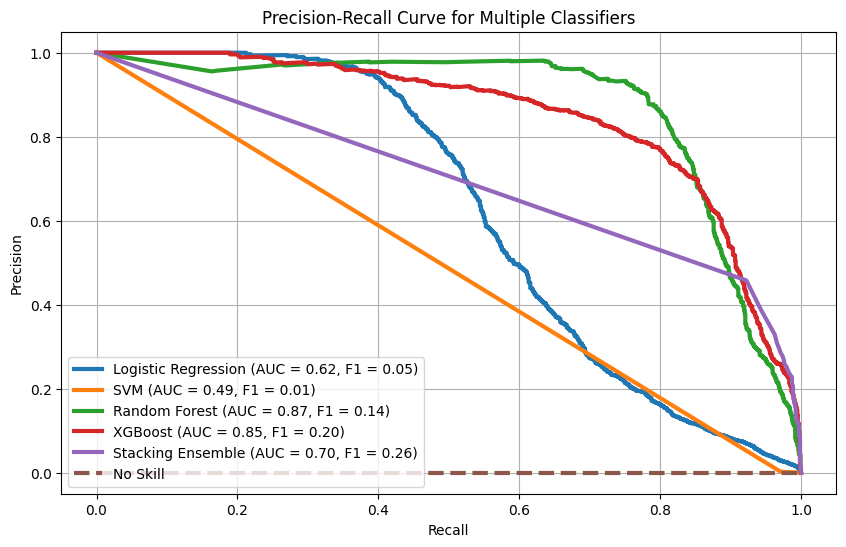

In [58]:
import matplotlib.pyplot as plt

# Initialize a figure for the plot
plt.figure(figsize=(10, 6))
    
# Loop through precision-recall curves and performance metrics
for classifier, precision, recall in precision_recall_curves:
    auc_value = auc(recall, precision)
    f1_score_value = performance_metrics[precision_recall_curves.index((classifier, precision, recall))]['F1-Score']
    
    # Plot precision-recall curve with thicker lines
    plt.plot(recall, precision, label=f'{classifier} (AUC = {auc_value:.2f}, F1 = {f1_score_value:.2f})', linewidth=3)

# Plot No Skill line
no_skill = len(y_val[y_val == 1]) / len(y_val)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill', linewidth=3)

# Axis labels and legend with adjusted position
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')  # Adjust the position of the legend to lower left
plt.title('Precision-Recall Curve for Multiple Classifiers')
plt.grid(True)

# Show the plot or save it to a file
plt.show()

In [48]:
from tabulate import tabulate

# Create a DataFrame from the performance_metrics list and round the values to 4 decimal places
metrics_df = pd.DataFrame(performance_metrics)
metrics_df = metrics_df.round(4)  # Round all values to 4 decimal places

# Use tabulate to display the performance metrics table
table = tabulate(metrics_df, headers='keys', tablefmt='pretty', showindex=False)

# Display the formatted table
print(table)

+---------------------+-----------+--------+----------+--------+
|     Classifier      | Precision | Recall | F1-Score |  AUC   |
+---------------------+-----------+--------+----------+--------+
| Logistic Regression |  0.0086   | 0.9937 |  0.0488  | 0.6199 |
|         SVM         |  0.2521   | 0.7355 |  0.0072  | 0.4874 |
|    Random Forest    |  0.0577   | 0.9924 |  0.1403  | 0.8693 |
|     XGBoosting      |  0.0127   | 0.9981 |  0.198   | 0.8468 |
|  Stacking Ensemble  |  0.0775   | 0.9955 |  0.2559  | 0.6968 |
+---------------------+-----------+--------+----------+--------+


# Future works:

Given the performance of the ensemble model is not satisfactory, future work can attempt the use of K-mean, DBSCAN and K-Nearest Neighbors (KNN) to further improve the model performance. K-means or DBSCAN can be applied to identify clusters or outliers in the dataset. While it's not a traditional classification model, it can assist in preprocessing or clustering to identify potential fraud patterns. Meanwhile, K-Nearest Neighbors (KNN) can be applied as a separate model after the ensemble model. It may work well if there are localized clusters of fraudulent activities.